In [43]:
# -*- coding: utf-8 -*-
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, label_binarize
import numpy as np
import torch.backends.cudnn as cudnn
from datetime import datetime
import matplotlib.pyplot as plt  # NEW: for line charts

# Global settings / reproducibility
cudnn.benchmark = True
torch.cuda.empty_cache()
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Root path to UCRArchive_2018
ROOT = r"D:\2025暑期科研\UCRArchive_2018\UCRArchive_2018"


In [44]:
def clean_and_pad_timeseries(raw_2d, min_len=8, cap_len=None, pad_value=0.0,
                             per_sample_standardize=True, fixed_len=None):
    """
    Clean time series with tail NaNs, z-score per-sample (optional), and pad/clip.

    Priority of output length:
      1) fixed_len: if not None, output length = fixed_len (force)
      2) cap_len:   if not None, output length = min(max_real_len, cap_len)
      3) otherwise, output length = max_real_len of this input batch
    """
    import numpy as np

    N, T = raw_2d.shape
    rows, keep_idx, real_lens = [], [], []

    for i in range(N):
        row = raw_2d[i]
        valid_vals = row[~np.isnan(row)]
        L = valid_vals.shape[0]
        if L < min_len:
            continue
        if per_sample_standardize:
            mu = valid_vals.mean()
            sigma = valid_vals.std()
            valid_vals = (valid_vals - mu) / (sigma if sigma > 0 else 1.0)
        rows.append(valid_vals); keep_idx.append(i); real_lens.append(L)

    if len(rows) == 0:
        raise ValueError("All samples filtered out. Lower min_len if needed.")

    max_real_len = max(real_lens)
    if fixed_len is not None:
        target_len = int(fixed_len)
    elif cap_len is not None:
        target_len = min(max_real_len, cap_len)
    else:
        target_len = max_real_len

    out = []
    for arr in rows:
        if arr.shape[0] >= target_len:
            arr = arr[:target_len]
        else:
            arr = np.pad(arr, (0, target_len - arr.shape[0]), constant_values=pad_value)
        out.append(arr)

    X = np.stack(out, axis=0).astype("float32")
    return X, np.array(keep_idx, dtype=np.int64), np.array(real_lens, dtype=np.int64)



In [45]:
class TwoTowerTransformer(nn.Module):
    """
    Two-tower Transformer:
      - Tower 1: time series tokens [B, T, 1] -> embed -> transformer
      - Tower 2: Aout vector [B, F] as a single token -> embed -> transformer
      - Concat tokens -> final transformer -> flatten -> FC for multi-class logits
    """
    def __init__(self, input_dim1, input_dim2,
                 hidden_dim1, hidden_dim2, hidden_dim3,
                 num_heads, num_layers, num_classes,
                 seq_len1, seq_len2):
        super().__init__()
        # To keep it simple we force equal hidden dims and divisibility by nhead
        assert hidden_dim1 == hidden_dim2 == hidden_dim3, "hidden dims must be equal in this version."
        for h in (hidden_dim1, hidden_dim2, hidden_dim3):
            assert h % num_heads == 0, "hidden_dim must be divisible by num_heads"

        self.embedding1 = nn.Linear(input_dim1, hidden_dim1)
        self.embedding2 = nn.Linear(input_dim2, hidden_dim2)
        self.relu = nn.ReLU()

        self.transformer1 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim1, nhead=num_heads, batch_first=True),
            num_layers=num_layers)

        self.transformer2 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim2, nhead=num_heads, batch_first=True),
            num_layers=num_layers)

        self.final_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim3, nhead=num_heads, batch_first=True),
            num_layers=num_layers)

        self.dropout = nn.Dropout(0.3)
        self.seq_len1 = seq_len1
        self.seq_len2 = 1  # treat Aout as a single token
        fc_in = hidden_dim3 * (seq_len1 + self.seq_len2)
        self.fc = nn.Linear(fc_in, num_classes)

    def forward(self, x1, x2):
        # x1: [B, T, input_dim1], x2: [B, F] or [B, 1, F]
        if x1.dim() == 2:
            x1 = x1.unsqueeze(-1)
        x1 = self.relu(self.embedding1(x1))
        x1 = self.transformer1(x1)

        if x2.dim() == 3:
            assert x2.size(1) == 1, "Expect x2 with L2=1 if 3D"
            x2 = x2.squeeze(1)
        x2 = self.relu(self.embedding2(x2))
        x2 = x2.unsqueeze(1)
        x2 = self.transformer2(x2)

        x = torch.cat((x1, x2), dim=1)
        x = self.final_transformer(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


class VisitDataset(Dataset):
    """Simple tensor dataset for (visit time series, aout features, one-hot labels)."""
    def __init__(self, visit_x, aout_x, y):
        self.visit_x = visit_x.astype("float32")
        self.aout_x  = aout_x.astype("float32")
        self.y       = y.astype("float32")
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.visit_x[idx], self.aout_x[idx], self.y[idx]


In [ ]:
def run_one_dataset(dataset_dir, dataset_name,
                    device='cuda:0',
                    batch_size=8, num_epochs=100, lr=1e-4,
                    cap_len=None,              # kept for compat; fixed_len dominates
                    patience=15,               # early stopping patience
                    verbose=False, plot_curves=True):
    import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
    import torch, torch.nn as nn, torch.optim as optim
    from torch.utils.data import DataLoader
    from torch.optim.lr_scheduler import CosineAnnealingLR
    from sklearn.preprocessing import StandardScaler, label_binarize
    from sklearn.metrics import accuracy_score, roc_auc_score

    # ---------- paths ----------
    tsv_train_path = os.path.join(dataset_dir, f"{dataset_name}_TRAIN_cleaned.tsv")
    tsv_test_path  = os.path.join(dataset_dir, f"{dataset_name}_TEST_cleaned.tsv")
    aout_train_csv = os.path.join(dataset_dir, f"{dataset_name}_Aout_train_k2.csv")
    aout_test_csv  = os.path.join(dataset_dir, f"{dataset_name}_Aout_test_k2.csv")
    if not all(os.path.exists(p) for p in [tsv_train_path, tsv_test_path, aout_train_csv, aout_test_csv]):
        print(f"⚠ Skip {dataset_name}, missing files"); return None

    # ---------- read (OFFICIAL split; do NOT concat) ----------
    tsv_tr = pd.read_csv(tsv_train_path, sep="\t", header=None)
    tsv_te = pd.read_csv(tsv_test_path,  sep="\t", header=None)
    csv_tr = pd.read_csv(aout_train_csv, header=None)
    csv_te = pd.read_csv(aout_test_csv,  header=None)

    y_tr_raw = tsv_tr.iloc[:,0].values
    y_te_raw = tsv_te.iloc[:,0].values
    visit_tr_raw = tsv_tr.iloc[:,1:].values.astype("float32")
    visit_te_raw = tsv_te.iloc[:,1:].values.astype("float32")
    aout_tr_raw_all  = csv_tr.iloc[:,1:].values.astype("float32")
    aout_te_raw_all  = csv_te.iloc[:,1:].values.astype("float32")

    # ---------- (1) determine TRAIN reference length ----------
    tmp_train_clean, keep_tr0, _ = clean_and_pad_timeseries(
        visit_tr_raw, min_len=8, cap_len=None, pad_value=0.0,
        per_sample_standardize=True, fixed_len=None
    )
    train_seq_len = tmp_train_clean.shape[1]

    # ---------- (2) re-clean TRAIN/TEST with fixed_len=train_seq_len ----------
    visit_tr_clean, keep_tr, _ = clean_and_pad_timeseries(
        visit_tr_raw, min_len=8, cap_len=None, pad_value=0.0,
        per_sample_standardize=True, fixed_len=train_seq_len
    )
    y_tr = y_tr_raw[keep_tr]
    aout_tr_raw = aout_tr_raw_all[keep_tr]

    visit_te_clean, keep_te, _ = clean_and_pad_timeseries(
        visit_te_raw, min_len=8, cap_len=None, pad_value=0.0,
        per_sample_standardize=True, fixed_len=train_seq_len
    )
    y_te = y_te_raw[keep_te]
    aout_te_raw = aout_te_raw_all[keep_te]

    # ---------- (3) scaler: fit on TRAIN only ----------
    scaler = StandardScaler().fit(aout_tr_raw)
    aout_tr = scaler.transform(aout_tr_raw).astype("float32")
    aout_te = scaler.transform(aout_te_raw).astype("float32")

    # ---------- (4) labels ----------
    classes = sorted(np.unique(y_tr))
    Y_tr = label_binarize(y_tr, classes=classes).astype("float32")
    Y_te = label_binarize(y_te, classes=classes).astype("float32")

    # left tower to [B, L, 1]
    visit_tr = visit_tr_clean[:, :, None]
    visit_te = visit_te_clean[:, :, None]

    # ---------- model dims ----------
    seq_len1 = visit_tr.shape[1]; seq_len2 = 1
    input_dim1 = visit_tr.shape[2]; input_dim2 = aout_tr.shape[1]
    num_classes = Y_tr.shape[1]

    hidden_dim1 = hidden_dim2 = hidden_dim3 = 16
    num_heads = 2; num_layers = 2

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = TwoTowerTransformer(
        input_dim1, input_dim2,
        hidden_dim1, hidden_dim2, hidden_dim3,
        num_heads, num_layers,
        num_classes,
        seq_len1, seq_len2
    ).to(device)
    if torch.cuda.device_count() > 1 and str(device).startswith('cuda'):
        model = nn.DataParallel(model, device_ids=[0,1])
    model = model.to(device)

    # loaders
    train_loader = DataLoader(VisitDataset(visit_tr, aout_tr, Y_tr),
                              batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
    test_loader  = DataLoader(VisitDataset(visit_te, aout_te, Y_te),
                              batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

    # loss/opt/sched
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

    # early stopping on TRAIN loss only
    class EarlyStopping:
        def __init__(self, patience=15, delta=0.0):
            self.patience = patience; self.delta = delta
            self.counter = 0; self.best = None; self.stop = False
        def step(self, train_loss):
            if self.best is None: self.best = train_loss; return False
            if train_loss > self.best - self.delta:
                self.counter += 1
                if self.counter >= self.patience: self.stop = True
            else:
                self.best = train_loss; self.counter = 0
            return self.stop

    es = EarlyStopping(patience=patience)

    # logging
    log_dir = os.path.join(dataset_dir, "_twotower_logs"); os.makedirs(log_dir, exist_ok=True)
    log_file = open(os.path.join(log_dir, "log_twotower.txt"), "w", encoding="utf-8")
    train_loss_hist = []

    # ---------- train (no test eval each epoch) ----------
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for x1,x2,y in train_loader:
            x1 = x1.to(torch.float32).to(device)
            x2 = x2.to(torch.float32).to(device)
            y  = y.to(torch.float32).to(device)
            optimizer.zero_grad()
            o = model(x1,x2)
            l = criterion(o,y)
            l.backward(); optimizer.step()
            total_loss += l.item()

        scheduler.step()
        avg_train_loss = total_loss / max(1,len(train_loader))
        train_loss_hist.append(avg_train_loss)
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}\n")

        if es.step(avg_train_loss):
            break

    log_file.close()

    # ---------- plot ONLY train loss ----------
    if plot_curves and len(train_loss_hist)>0:
        fig,ax=plt.subplots(figsize=(6,4))
        ax.plot(range(1,len(train_loss_hist)+1), train_loss_hist, label="Train Loss")
        ax.set_xlabel("Epoch"); ax.set_ylabel("Loss"); ax.grid(True); ax.legend()
        ax.set_title(f"{dataset_name} - Train Loss")
        plt.tight_layout(); plt.savefig(os.path.join(log_dir, f"{dataset_name}_train_loss.png"), dpi=150); plt.show()

    # ---------- TEST evaluation (run once after training) ----------
    model.eval()
    tout=[]; tlab=[]
    with torch.no_grad():
        for x1,x2,y in test_loader:
            x1 = x1.to(torch.float32).to(device)
            x2 = x2.to(torch.float32).to(device)
            o = model(x1,x2)
            tout.append(o.detach().cpu().numpy()); tlab.append(y.numpy())
    tout = np.concatenate(tout); tlab = np.concatenate(tlab)
    try:  test_auc = roc_auc_score(tlab, tout, multi_class='ovr')
    except: test_auc = roc_auc_score(tlab, tout)
    test_pred = np.argmax(tout, axis=1)
    test_true = np.argmax(tlab, axis=1)
    test_acc = accuracy_score(test_true, test_pred)
    test_n = len(tlab)

    print(f"[{dataset_name}] TEST AUC={test_auc:.4f}, TEST ACC={test_acc:.4f}, n_samples={test_n}")
    return test_auc, test_acc, test_n





In [47]:
def discover_datasets(root):
    """
    Discover dataset subfolders that contain all four required files:
      *_TRAIN_cleaned.tsv, *_TEST_cleaned.tsv, *_Aout_train_k2.csv, *_Aout_test_k2.csv
    Returns: a sorted list of dataset names (folder names).
    """
    names = []
    for name in sorted(os.listdir(root)):
        subdir = os.path.join(root, name)
        if not os.path.isdir(subdir):
            continue
        t_train = os.path.join(subdir, f"{name}_TRAIN_cleaned.tsv")
        t_test  = os.path.join(subdir, f"{name}_TEST_cleaned.tsv")
        a_train = os.path.join(subdir, f"{name}_Aout_train_k2.csv")
        a_test  = os.path.join(subdir, f"{name}_Aout_test_k2.csv")
        if all(os.path.exists(p) for p in [t_train, t_test, a_train, a_test]):
            names.append(name)
    return names


In [48]:
def run_all_datasets(root, device='cuda:0',
                     batch_size=8, num_epochs=100, lr=1e-4,
                     cap_len=None, verbose=False, plot_curves=True,
                     patience=15):
    import os, pandas as pd
    from datetime import datetime
    dataset_names = discover_datasets(root)
    print(f"Found {len(dataset_names)} datasets:", dataset_names)

    rows = []
    for name in dataset_names:
        out = run_one_dataset(
            dataset_dir=os.path.join(root, name),
            dataset_name=name,
            device=device,
            batch_size=batch_size, num_epochs=num_epochs, lr=lr,
            cap_len=cap_len,
            patience=patience, # 仅透传 patience
            verbose=verbose, plot_curves=plot_curves
        )
        if out is None: continue
        test_auc, test_acc, test_n = out
        rows.append((name, test_auc, test_acc, test_n))

    if not rows:
        print("No dataset finished successfully."); return None

    df = pd.DataFrame(rows, columns=["dataset", "test_auc", "test_acc", "n_samples"])
    mean_auc = df["test_auc"].mean(); mean_acc = df["test_acc"].mean()
    w_auc = (df["test_auc"] * df["n_samples"]).sum() / df["n_samples"].sum()
    w_acc = (df["test_acc"] * df["n_samples"]).sum() / df["n_samples"].sum()

    print("\n========== Summary (OFFICIAL TEST) ==========")
    print(df.sort_values("dataset").to_string(index=False))
    print(f"\nSimple mean: AUC = {mean_auc:.4f}, ACC = {mean_acc:.4f}")
    print(f"Weighted (by samples): AUC = {w_auc:.4f}, ACC = {w_acc:.4f}")

    summary_dir = os.path.join(root, "_twotower_logs"); os.makedirs(summary_dir, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    df.to_csv(os.path.join(summary_dir, f"summary_TEST_{ts}.csv"), index=False, encoding="utf-8")
    with open(os.path.join(summary_dir, f"summary_TEST_{ts}.txt"), "w", encoding="utf-8") as f:
        f.write(df.sort_values("dataset").to_string(index=False))
        f.write(f"\n\nSimple mean: AUC={mean_auc:.6f}, ACC={mean_acc:.6f}\n")
        f.write(f"Weighted (by samples): AUC={w_auc:.6f}, ACC={w_acc:.6f}\n")

    return df, (mean_auc, mean_acc), (w_auc, w_acc)






Found 125 datasets: ['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'BME', 'Beef', 'BeetleFly', 'BirdChicken', 'CBF', 'Car', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'ECG200', 'ECG5000', 'ECGFiveDays', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'Earthquakes', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbea

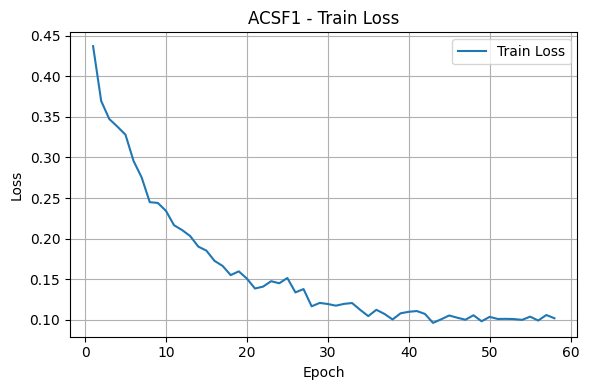

[ACSF1] TEST AUC=0.9473, TEST ACC=0.7000, n_samples=100


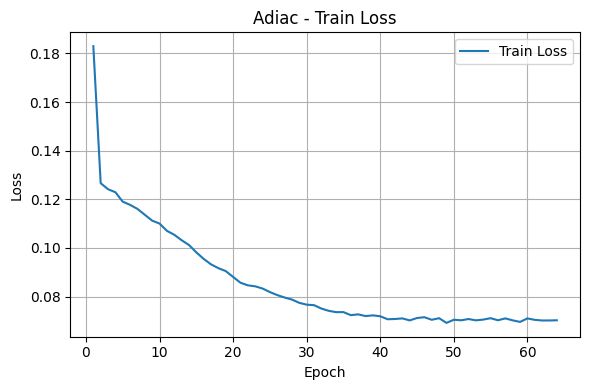

[Adiac] TEST AUC=0.9379, TEST ACC=0.4501, n_samples=391


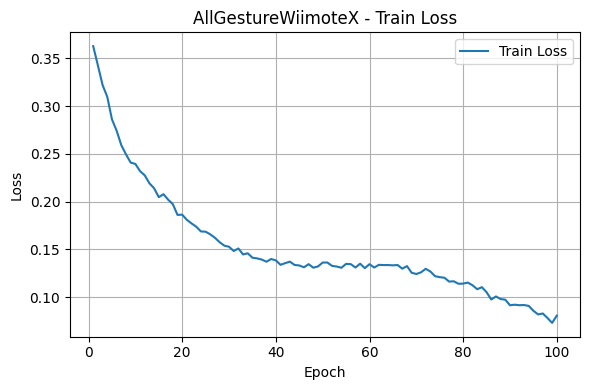

[AllGestureWiimoteX] TEST AUC=0.7822, TEST ACC=0.3862, n_samples=681


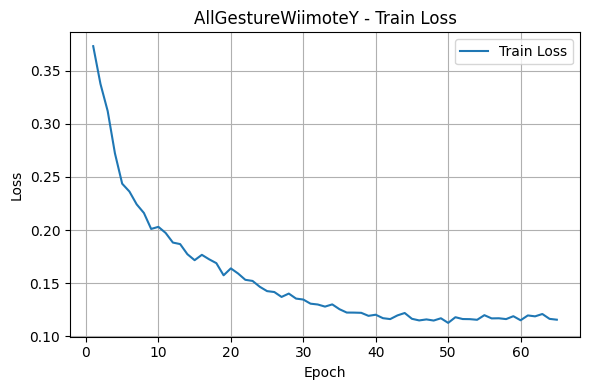

[AllGestureWiimoteY] TEST AUC=0.8673, TEST ACC=0.4946, n_samples=645


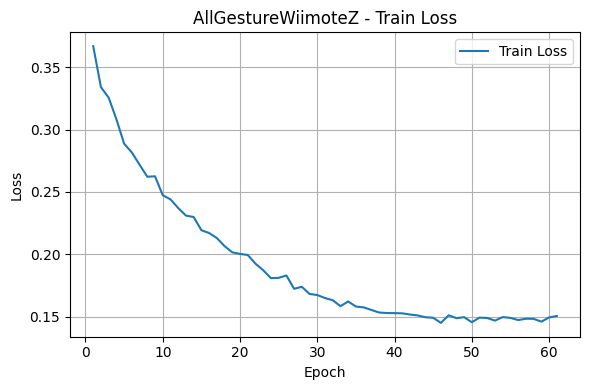

[AllGestureWiimoteZ] TEST AUC=0.8012, TEST ACC=0.3518, n_samples=685


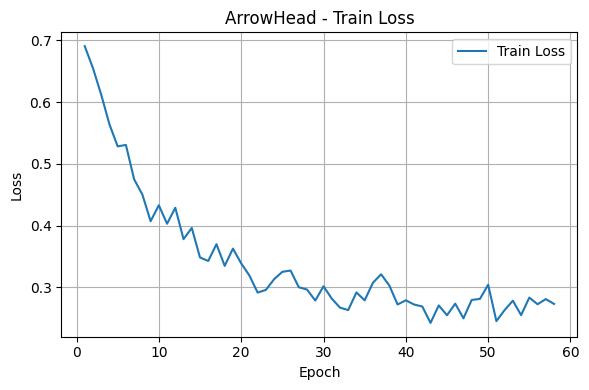

[ArrowHead] TEST AUC=0.8670, TEST ACC=0.6400, n_samples=175


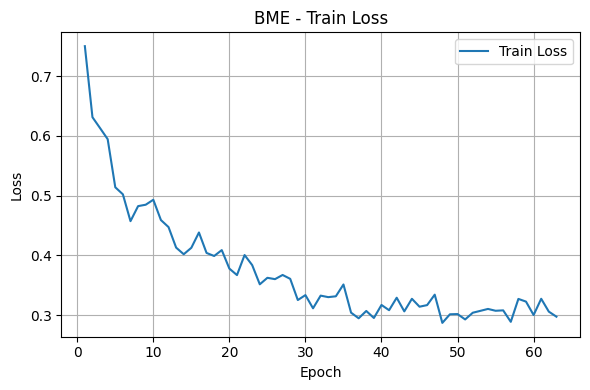

[BME] TEST AUC=0.9234, TEST ACC=0.7533, n_samples=150


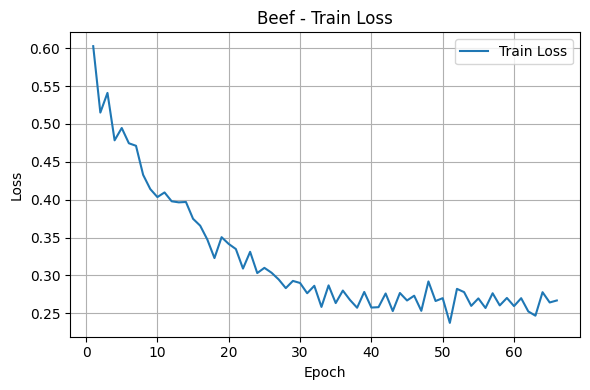

[Beef] TEST AUC=0.8806, TEST ACC=0.7333, n_samples=30


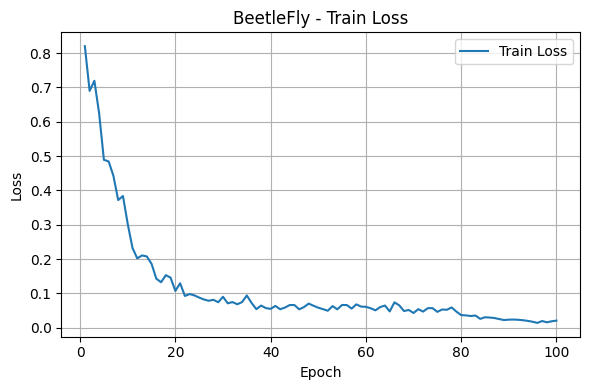

[BeetleFly] TEST AUC=0.8500, TEST ACC=1.0000, n_samples=20


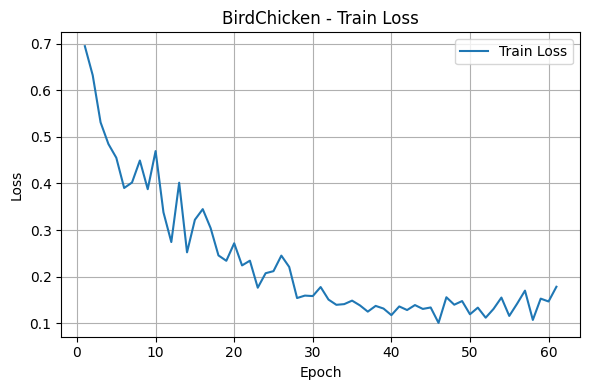

[BirdChicken] TEST AUC=0.7300, TEST ACC=1.0000, n_samples=20


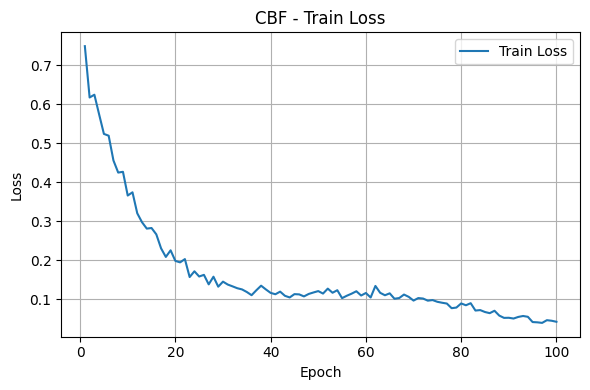

[CBF] TEST AUC=0.9969, TEST ACC=0.9756, n_samples=900


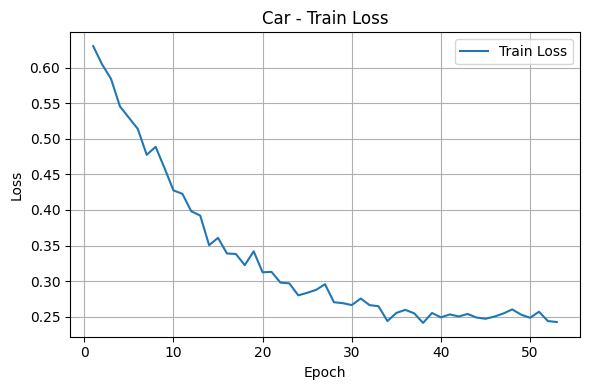

[Car] TEST AUC=0.8783, TEST ACC=0.7000, n_samples=60


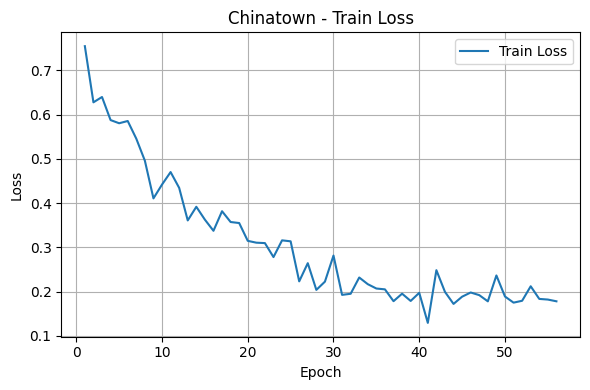

[Chinatown] TEST AUC=0.9698, TEST ACC=1.0000, n_samples=343


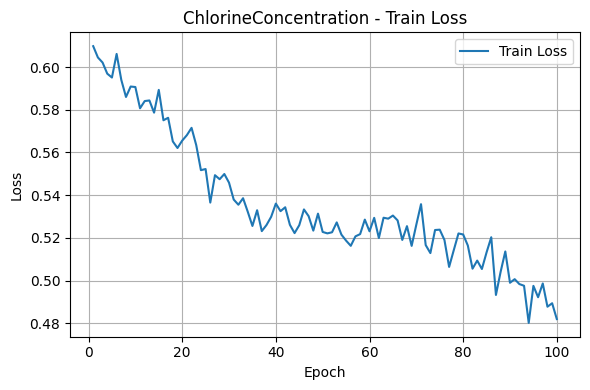

[ChlorineConcentration] TEST AUC=0.6980, TEST ACC=0.5758, n_samples=3840


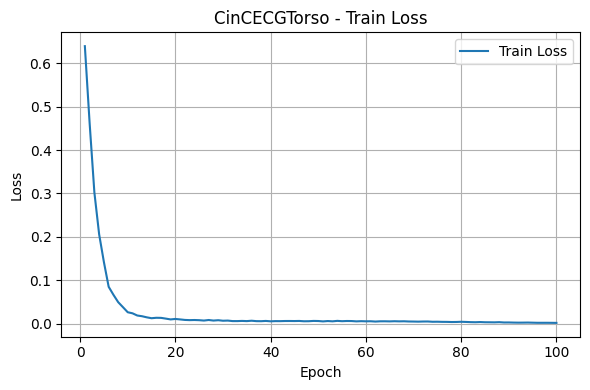

[CinCECGTorso] TEST AUC=0.9953, TEST ACC=0.9094, n_samples=1380


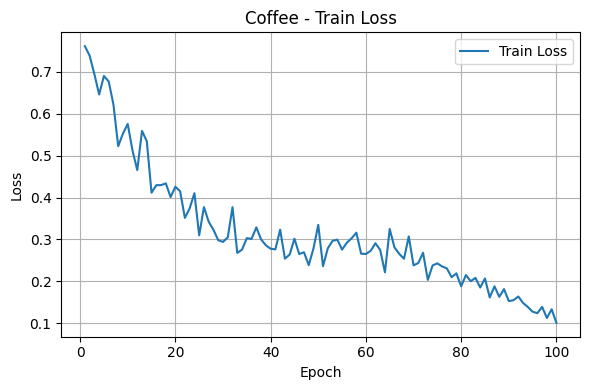

[Coffee] TEST AUC=0.9949, TEST ACC=1.0000, n_samples=28


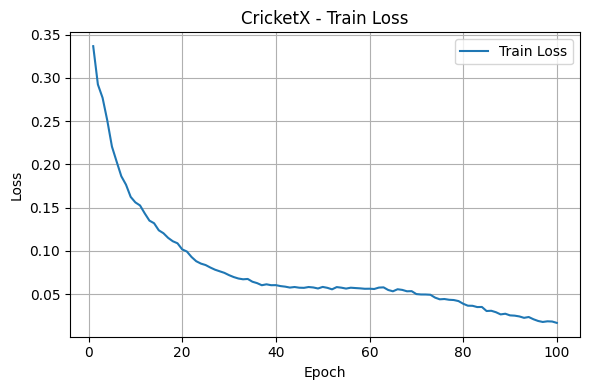

[CricketX] TEST AUC=0.8916, TEST ACC=0.5718, n_samples=390


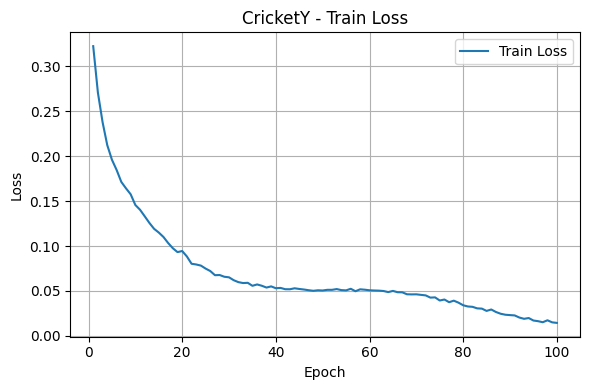

[CricketY] TEST AUC=0.9049, TEST ACC=0.5538, n_samples=390


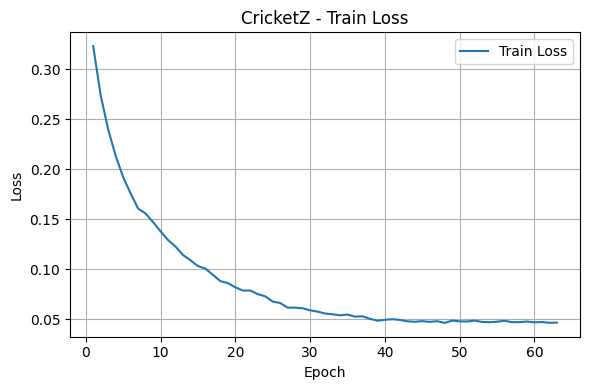

[CricketZ] TEST AUC=0.8810, TEST ACC=0.5769, n_samples=390


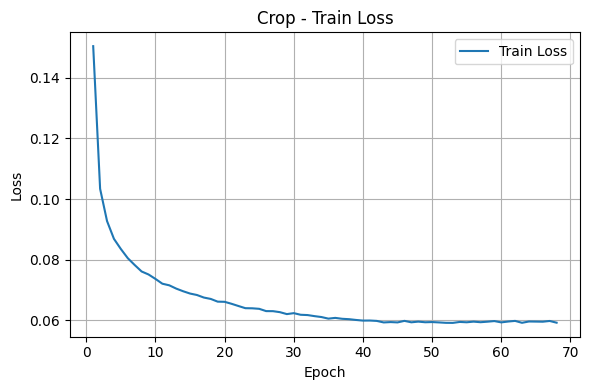

[Crop] TEST AUC=0.9616, TEST ACC=0.6880, n_samples=16778


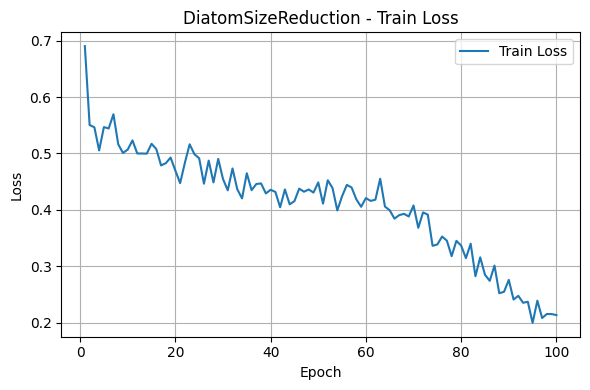

[DiatomSizeReduction] TEST AUC=0.9764, TEST ACC=0.8824, n_samples=306


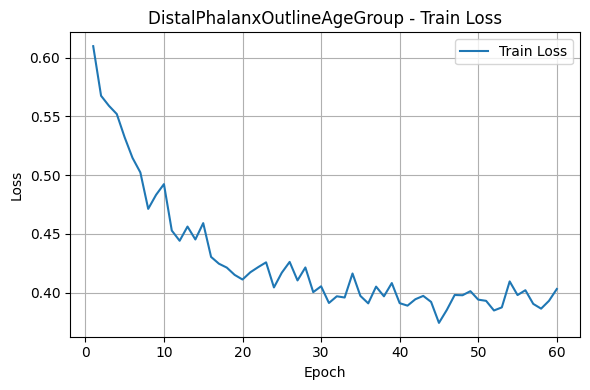

[DistalPhalanxOutlineAgeGroup] TEST AUC=0.8088, TEST ACC=0.6869, n_samples=99


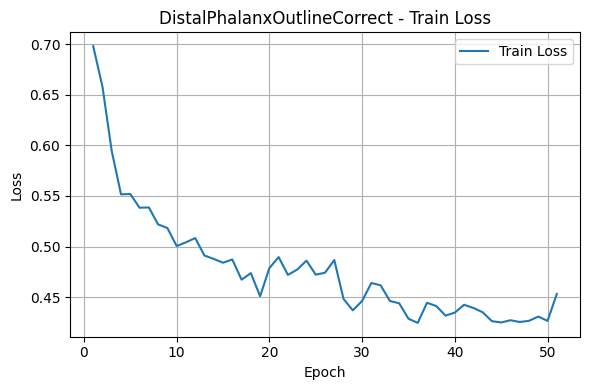

[DistalPhalanxOutlineCorrect] TEST AUC=0.8184, TEST ACC=1.0000, n_samples=199


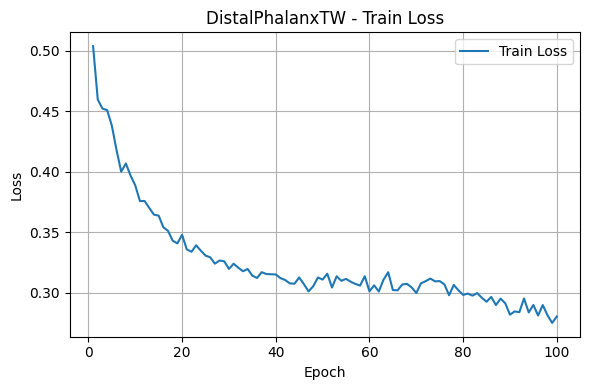

[DistalPhalanxTW] TEST AUC=0.8246, TEST ACC=0.5532, n_samples=94


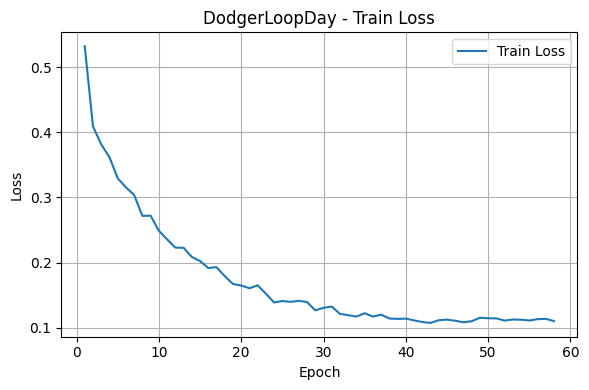

[DodgerLoopDay] TEST AUC=0.8261, TEST ACC=0.4875, n_samples=80


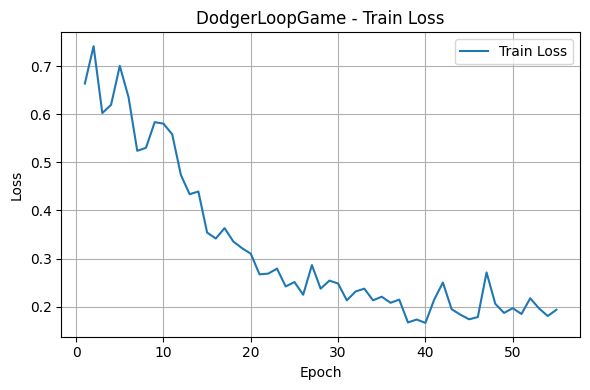

[DodgerLoopGame] TEST AUC=0.8169, TEST ACC=1.0000, n_samples=138


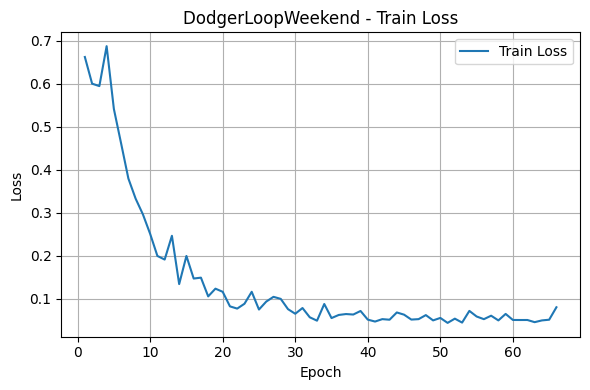

[DodgerLoopWeekend] TEST AUC=0.9845, TEST ACC=1.0000, n_samples=138


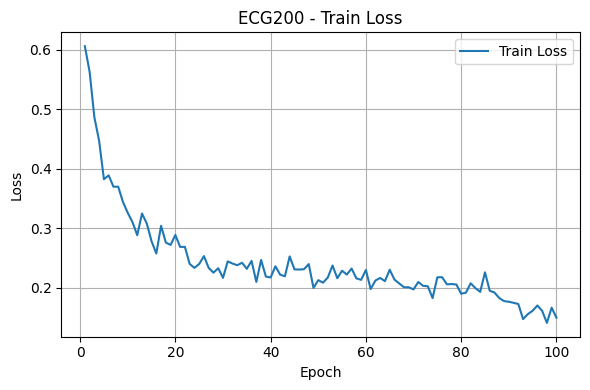

[ECG200] TEST AUC=0.9110, TEST ACC=1.0000, n_samples=100


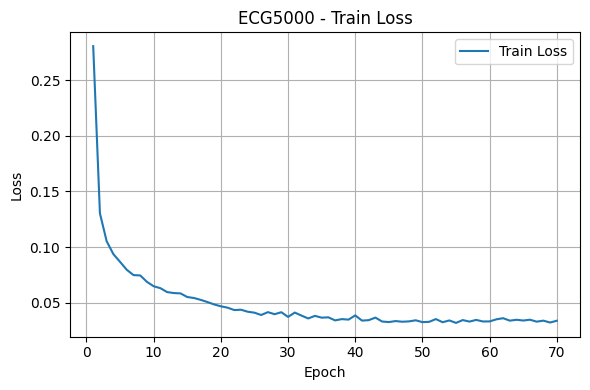

[ECG5000] TEST AUC=0.9201, TEST ACC=0.9389, n_samples=4500


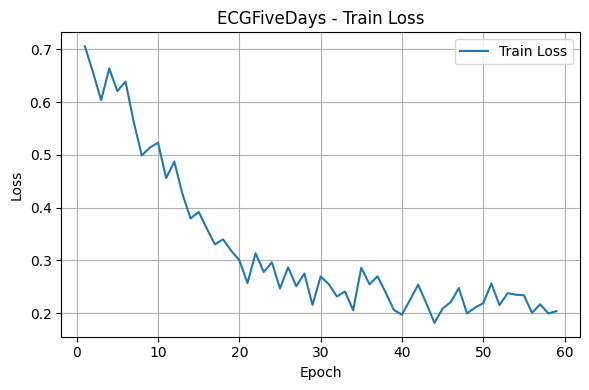

[ECGFiveDays] TEST AUC=0.8831, TEST ACC=1.0000, n_samples=861


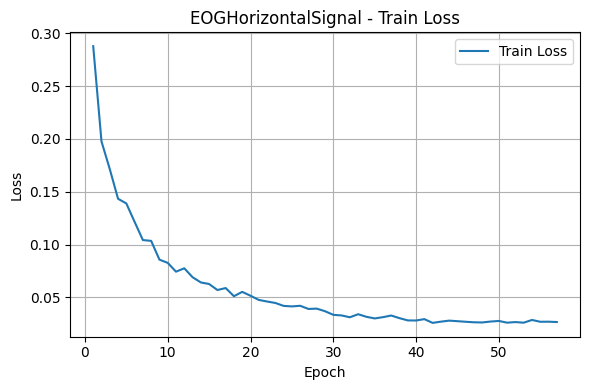

[EOGHorizontalSignal] TEST AUC=0.8485, TEST ACC=0.4972, n_samples=362


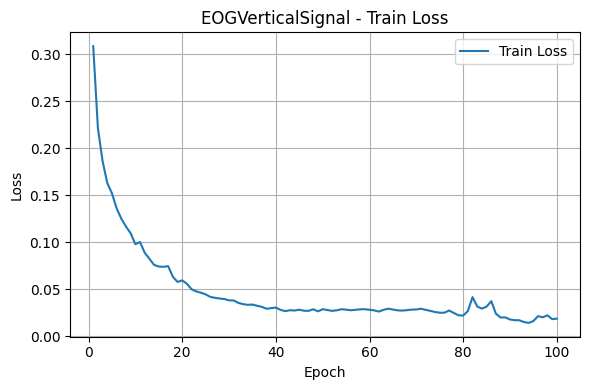

[EOGVerticalSignal] TEST AUC=0.8229, TEST ACC=0.4227, n_samples=362


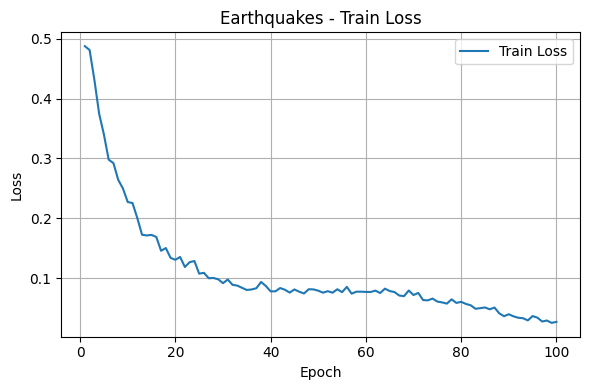

[Earthquakes] TEST AUC=0.6288, TEST ACC=1.0000, n_samples=139


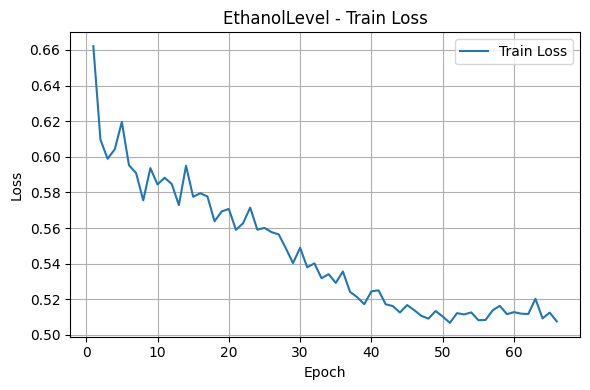

[EthanolLevel] TEST AUC=0.5296, TEST ACC=0.2780, n_samples=500


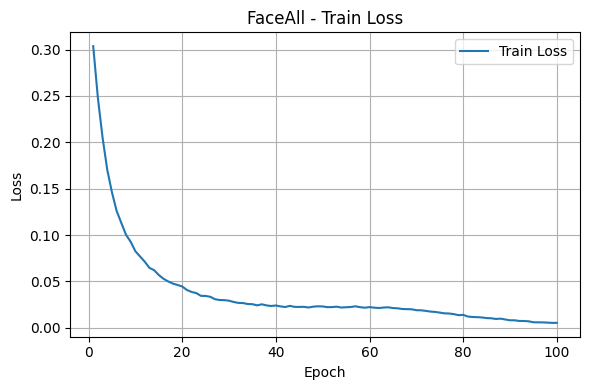

[FaceAll] TEST AUC=0.9500, TEST ACC=0.7379, n_samples=1690


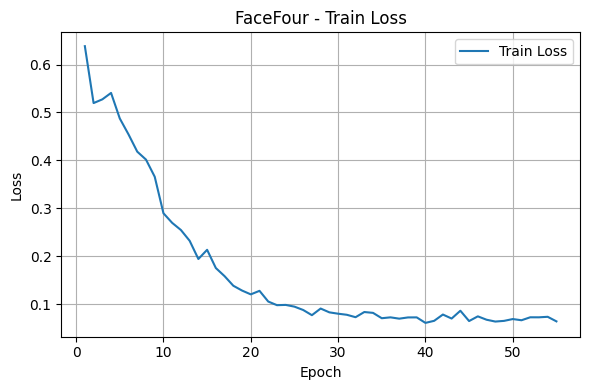

[FaceFour] TEST AUC=0.9530, TEST ACC=0.8765, n_samples=81


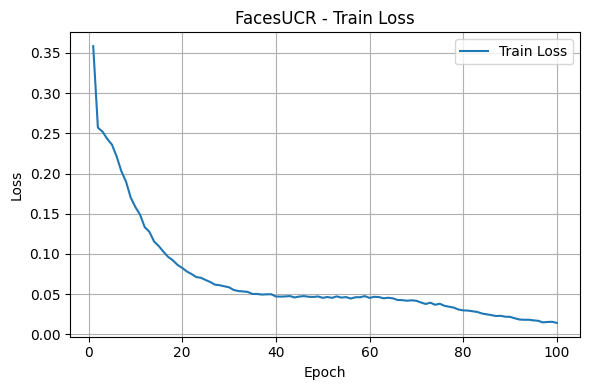

[FacesUCR] TEST AUC=0.9554, TEST ACC=0.8302, n_samples=2050


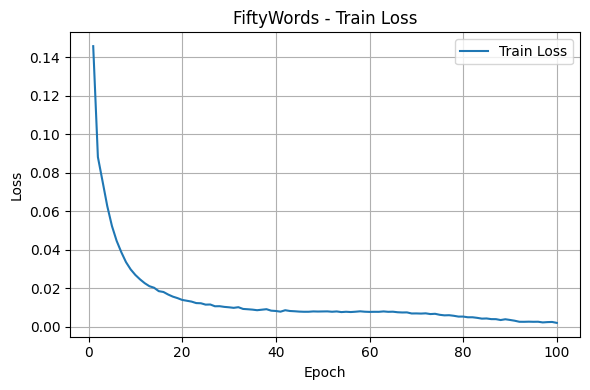

[FiftyWords] TEST AUC=0.9055, TEST ACC=0.6857, n_samples=455


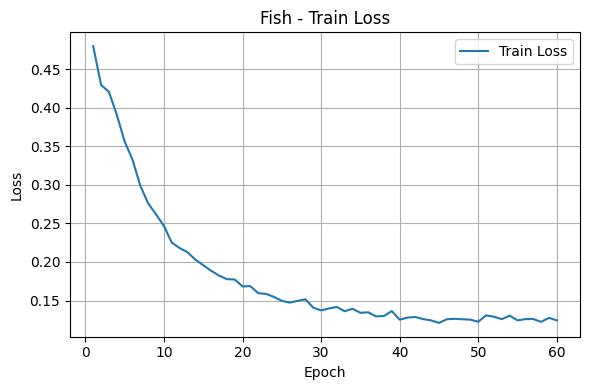

[Fish] TEST AUC=0.9386, TEST ACC=0.7600, n_samples=175


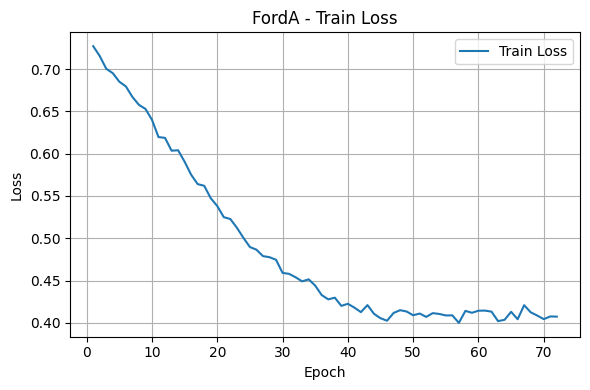

[FordA] TEST AUC=0.5441, TEST ACC=1.0000, n_samples=1320


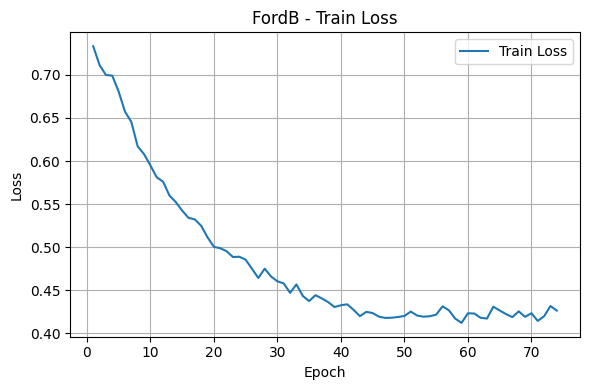

[FordB] TEST AUC=0.5529, TEST ACC=1.0000, n_samples=810


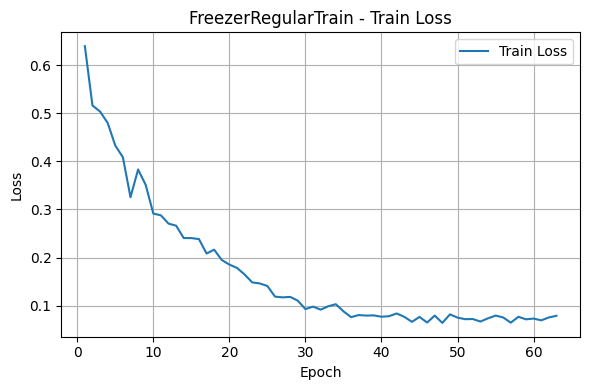

[FreezerRegularTrain] TEST AUC=0.9918, TEST ACC=1.0000, n_samples=2850


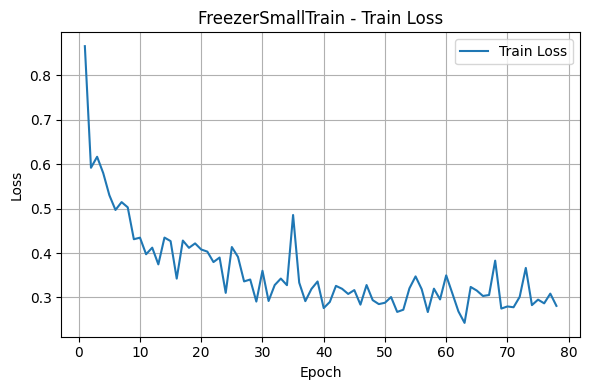

[FreezerSmallTrain] TEST AUC=0.8141, TEST ACC=1.0000, n_samples=2850


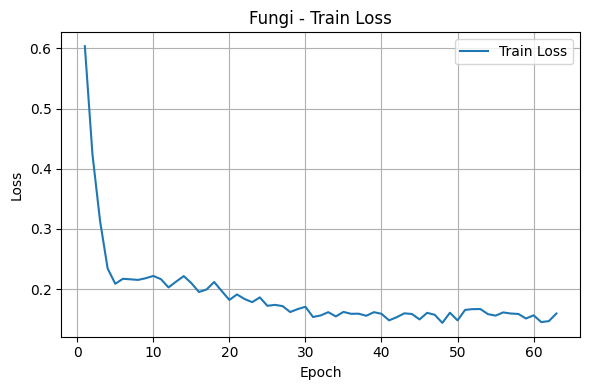

[Fungi] TEST AUC=0.9784, TEST ACC=0.7527, n_samples=186


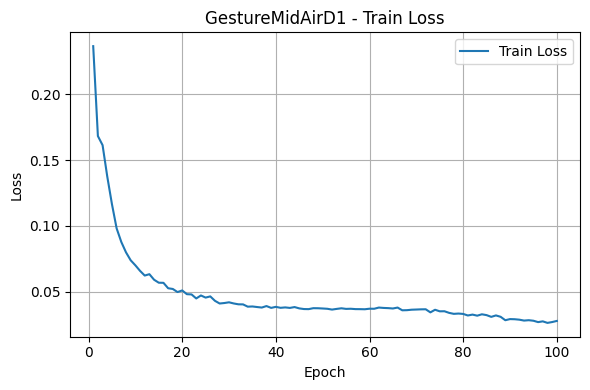

[GestureMidAirD1] TEST AUC=0.9644, TEST ACC=0.6231, n_samples=130


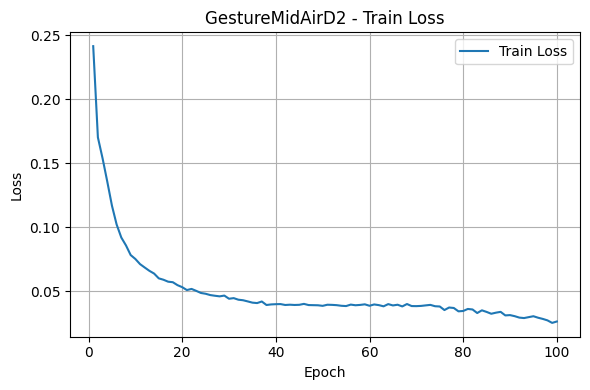

[GestureMidAirD2] TEST AUC=0.9606, TEST ACC=0.5923, n_samples=130


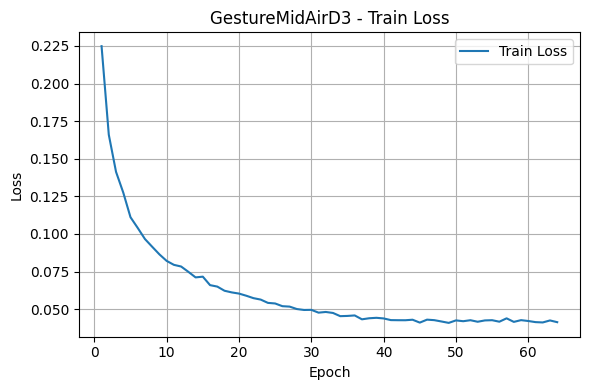

[GestureMidAirD3] TEST AUC=0.9209, TEST ACC=0.4231, n_samples=130


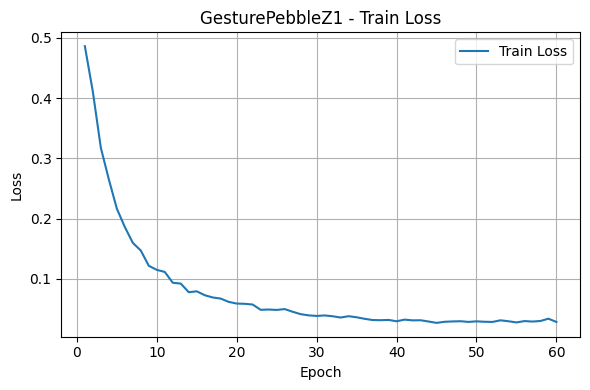

[GesturePebbleZ1] TEST AUC=0.9648, TEST ACC=0.8198, n_samples=172


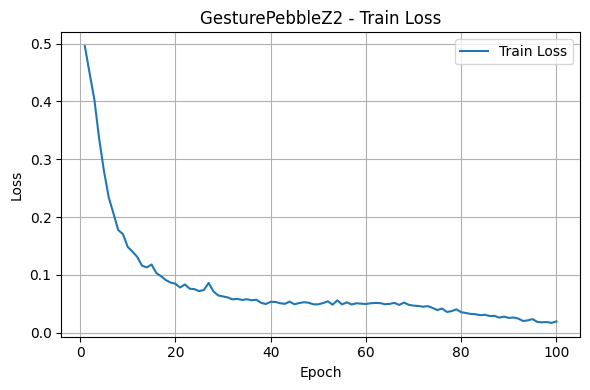

[GesturePebbleZ2] TEST AUC=0.9732, TEST ACC=0.8038, n_samples=158


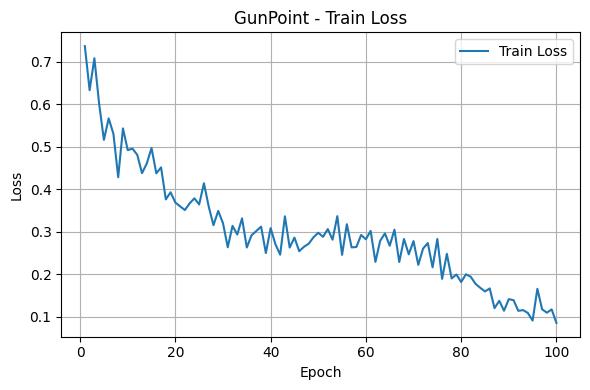

[GunPoint] TEST AUC=0.9984, TEST ACC=1.0000, n_samples=150


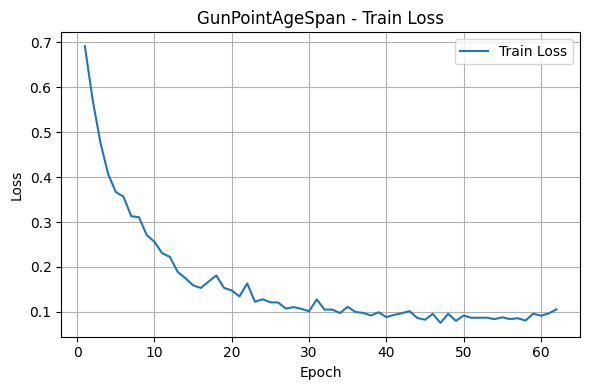

[GunPointAgeSpan] TEST AUC=0.9925, TEST ACC=1.0000, n_samples=316


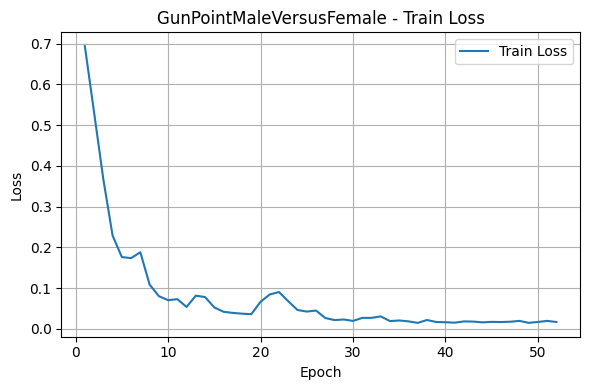

[GunPointMaleVersusFemale] TEST AUC=0.9981, TEST ACC=1.0000, n_samples=316


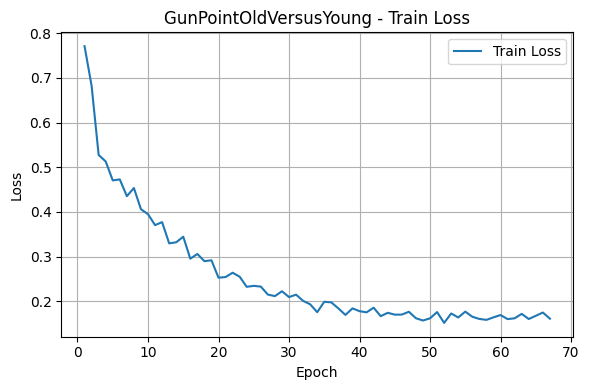

[GunPointOldVersusYoung] TEST AUC=0.9906, TEST ACC=1.0000, n_samples=315


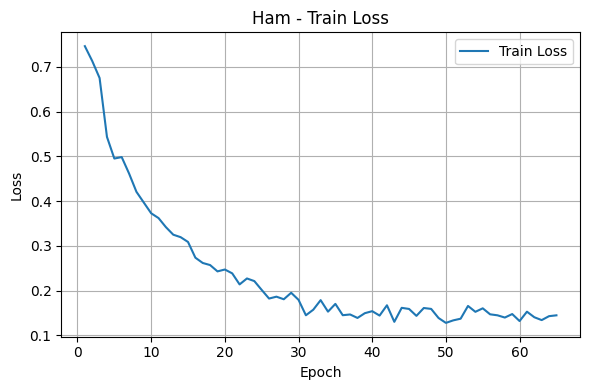

[Ham] TEST AUC=0.8420, TEST ACC=1.0000, n_samples=105


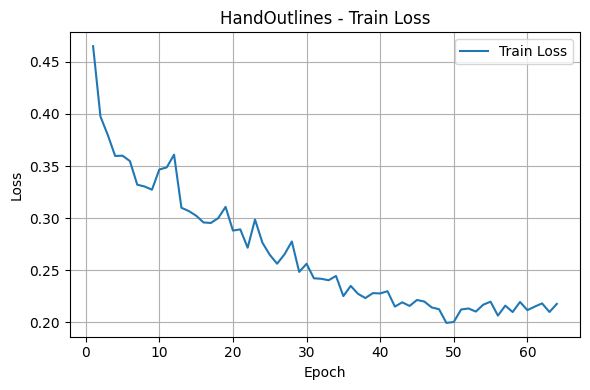

[HandOutlines] TEST AUC=0.9391, TEST ACC=1.0000, n_samples=370


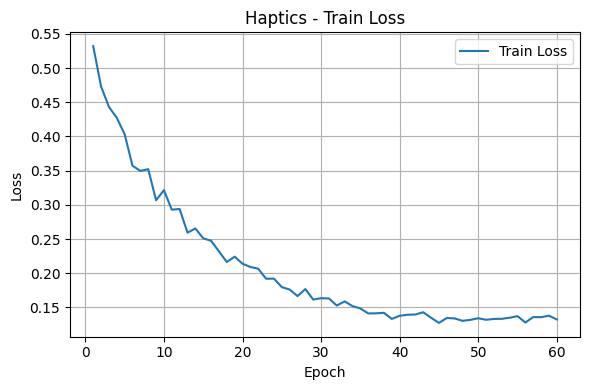

[Haptics] TEST AUC=0.7140, TEST ACC=0.4318, n_samples=308


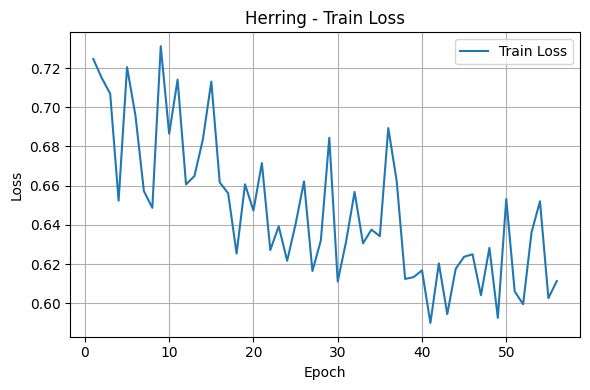

[Herring] TEST AUC=0.5709, TEST ACC=1.0000, n_samples=64


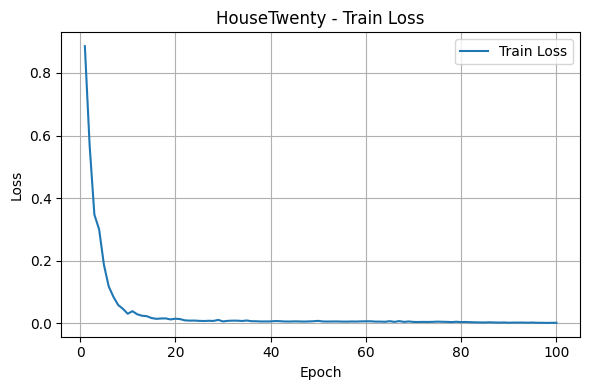

[HouseTwenty] TEST AUC=0.9148, TEST ACC=1.0000, n_samples=119


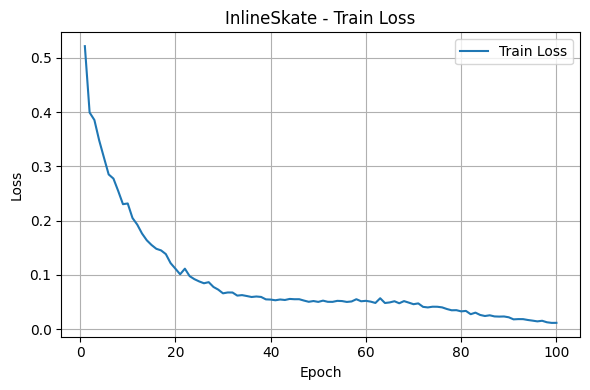

[InlineSkate] TEST AUC=0.6684, TEST ACC=0.3055, n_samples=550


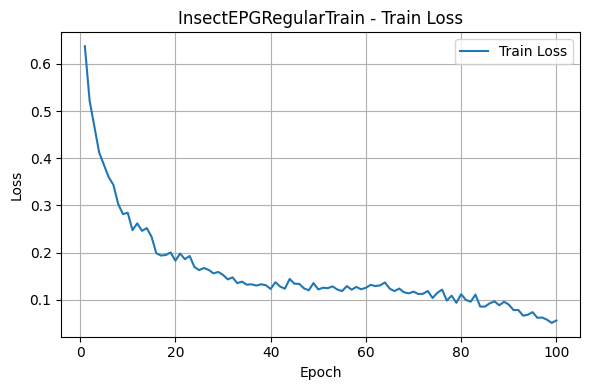

[InsectEPGRegularTrain] TEST AUC=0.8421, TEST ACC=0.6747, n_samples=249


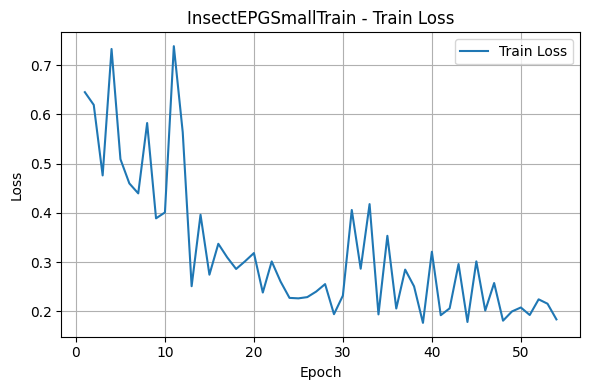

[InsectEPGSmallTrain] TEST AUC=0.8046, TEST ACC=0.6908, n_samples=249


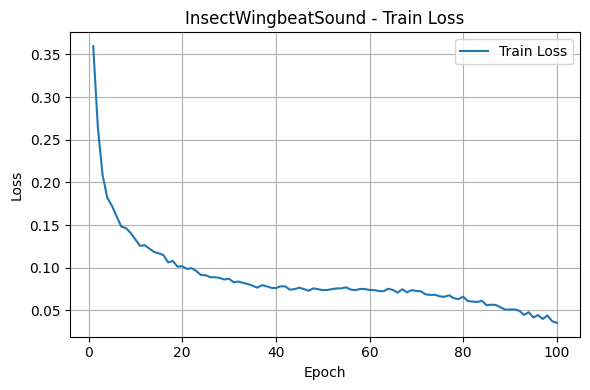

[InsectWingbeatSound] TEST AUC=0.9384, TEST ACC=0.6278, n_samples=1980


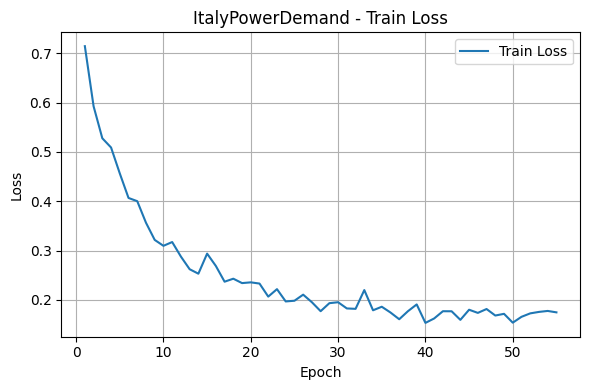

[ItalyPowerDemand] TEST AUC=0.9866, TEST ACC=1.0000, n_samples=1028


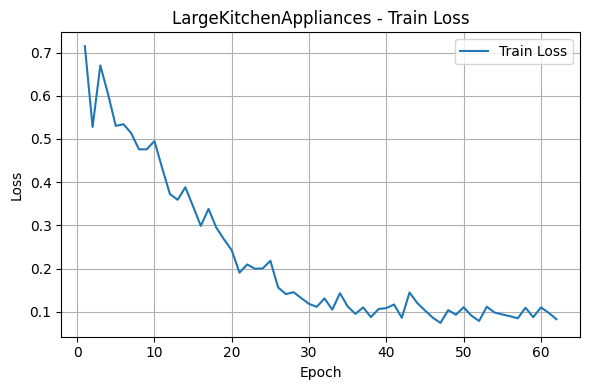

[LargeKitchenAppliances] TEST AUC=0.5476, TEST ACC=0.4118, n_samples=17


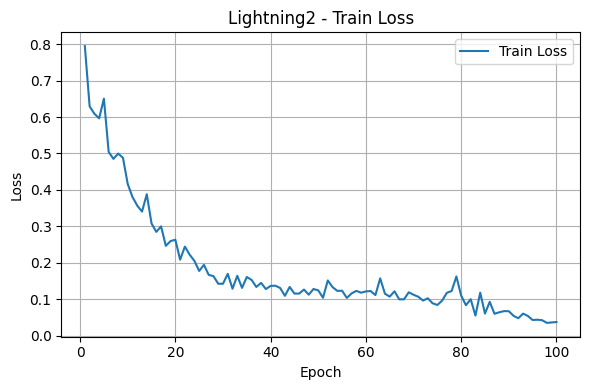

[Lightning2] TEST AUC=0.8171, TEST ACC=1.0000, n_samples=61


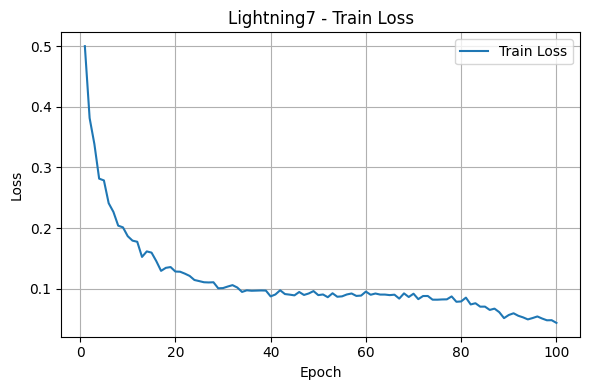

[Lightning7] TEST AUC=0.9497, TEST ACC=0.6712, n_samples=73


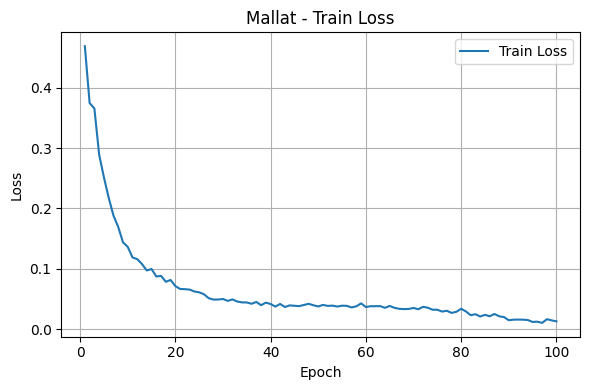

[Mallat] TEST AUC=0.9980, TEST ACC=0.9232, n_samples=2345


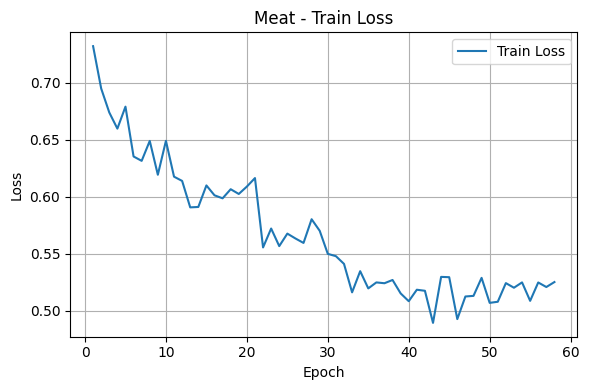

[Meat] TEST AUC=0.9729, TEST ACC=0.8500, n_samples=60


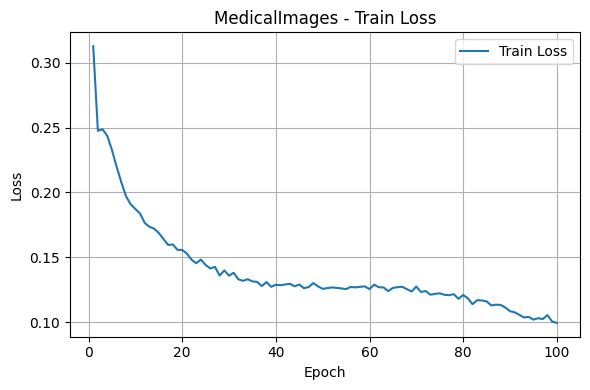

[MedicalImages] TEST AUC=0.9270, TEST ACC=0.6513, n_samples=760


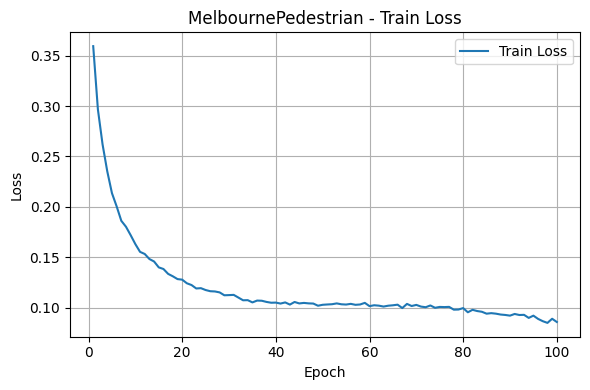

[MelbournePedestrian] TEST AUC=0.9695, TEST ACC=0.8429, n_samples=2425


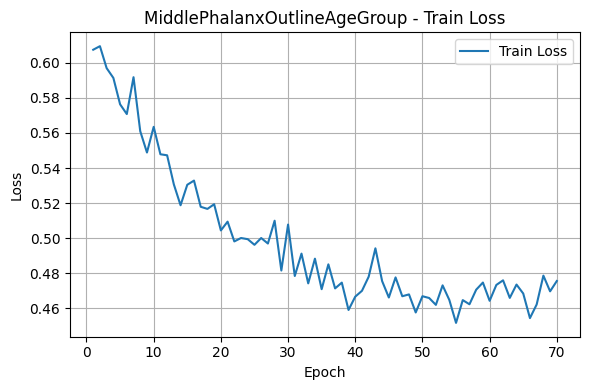

[MiddlePhalanxOutlineAgeGroup] TEST AUC=0.5393, TEST ACC=0.5782, n_samples=147


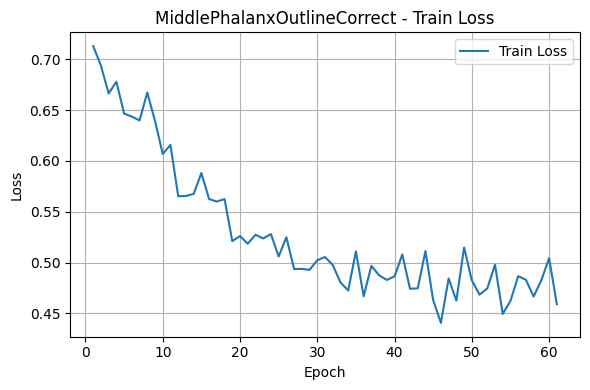

[MiddlePhalanxOutlineCorrect] TEST AUC=0.8466, TEST ACC=1.0000, n_samples=276


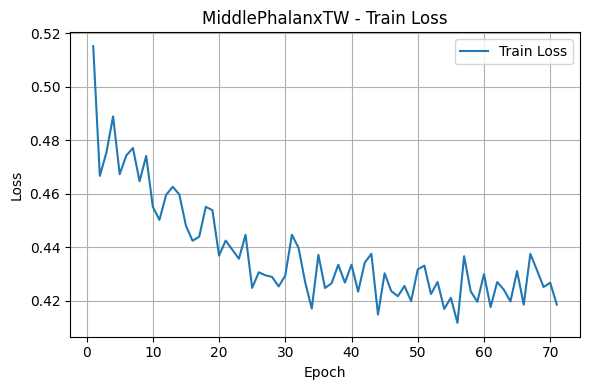

[MiddlePhalanxTW] TEST AUC=0.6343, TEST ACC=0.4000, n_samples=110


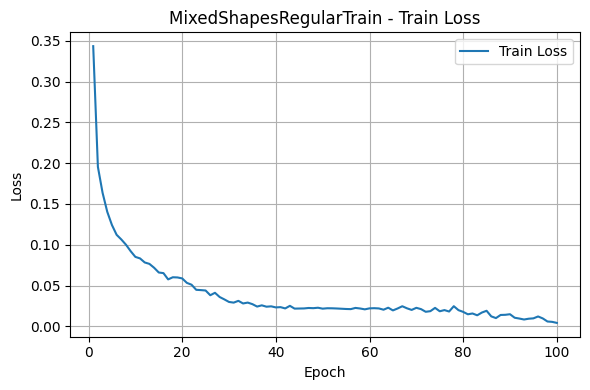

[MixedShapesRegularTrain] TEST AUC=0.9560, TEST ACC=0.8540, n_samples=2425


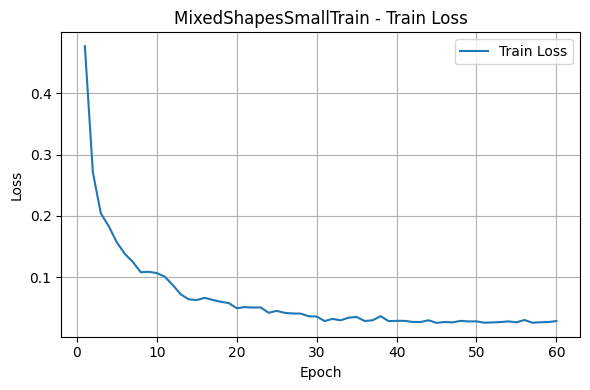

[MixedShapesSmallTrain] TEST AUC=0.9384, TEST ACC=0.8243, n_samples=2425


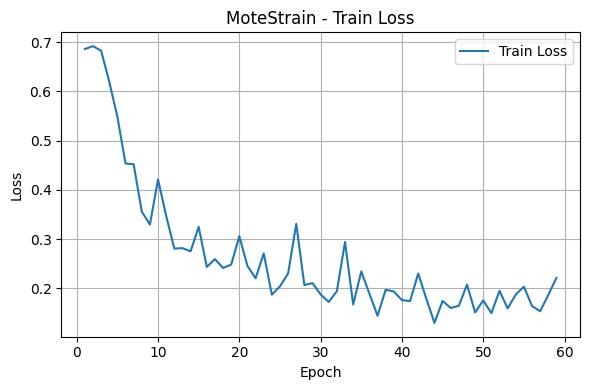

[MoteStrain] TEST AUC=0.9631, TEST ACC=1.0000, n_samples=1238


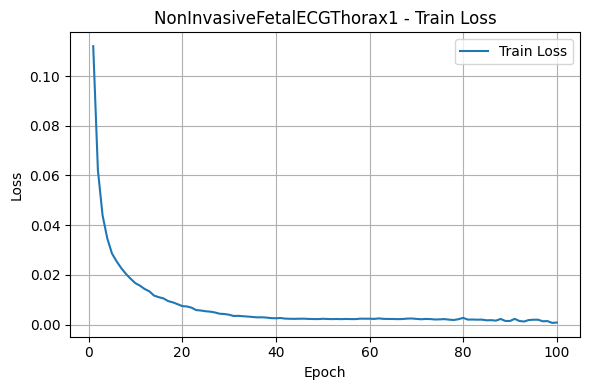

[NonInvasiveFetalECGThorax1] TEST AUC=0.9926, TEST ACC=0.8595, n_samples=1965


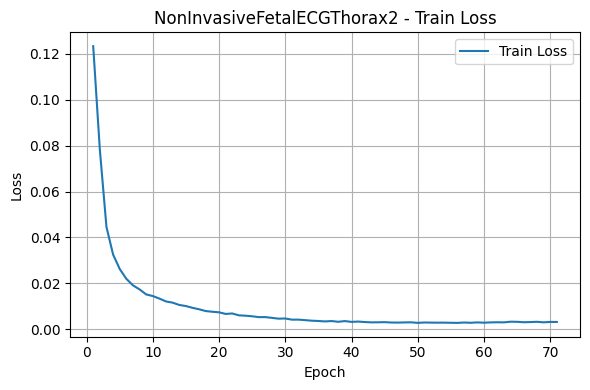

[NonInvasiveFetalECGThorax2] TEST AUC=0.9974, TEST ACC=0.9252, n_samples=1965


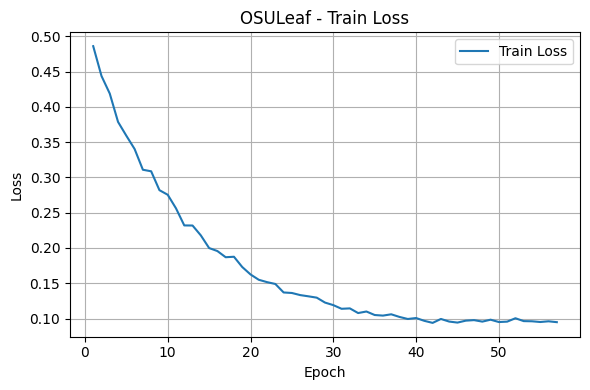

[OSULeaf] TEST AUC=0.7640, TEST ACC=0.5165, n_samples=242


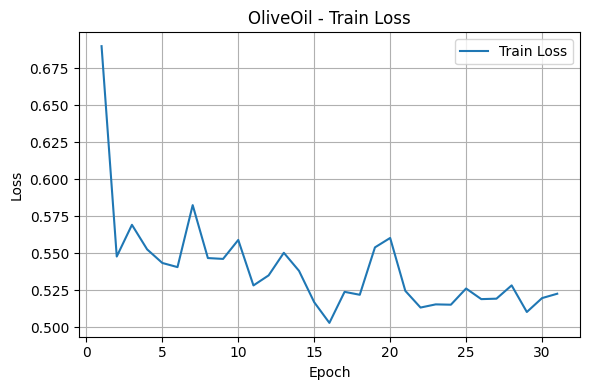

[OliveOil] TEST AUC=0.8359, TEST ACC=0.4000, n_samples=30


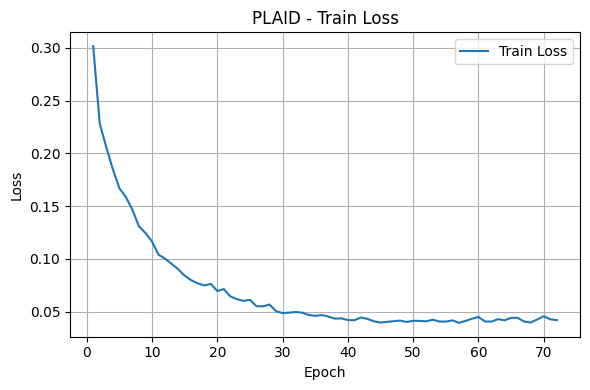

[PLAID] TEST AUC=0.9391, TEST ACC=0.7412, n_samples=537


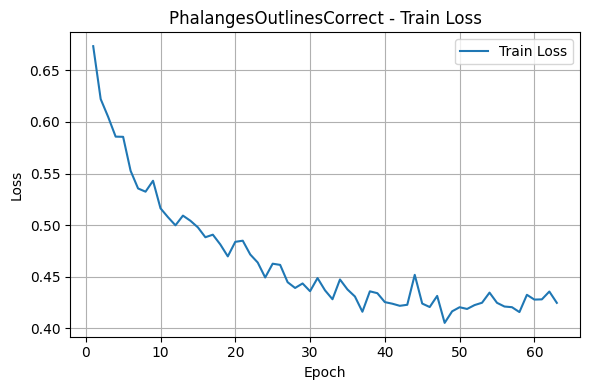

[PhalangesOutlinesCorrect] TEST AUC=0.8654, TEST ACC=1.0000, n_samples=596


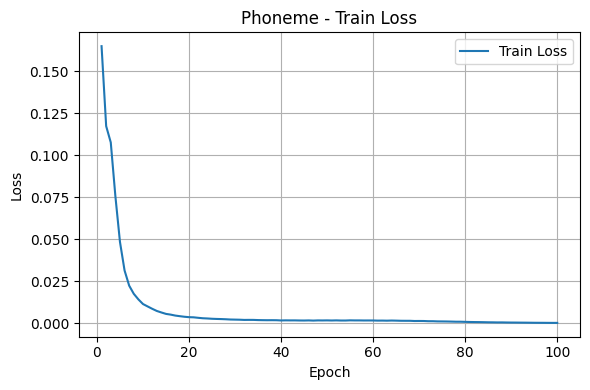

[Phoneme] TEST AUC=0.5951, TEST ACC=0.1257, n_samples=1894


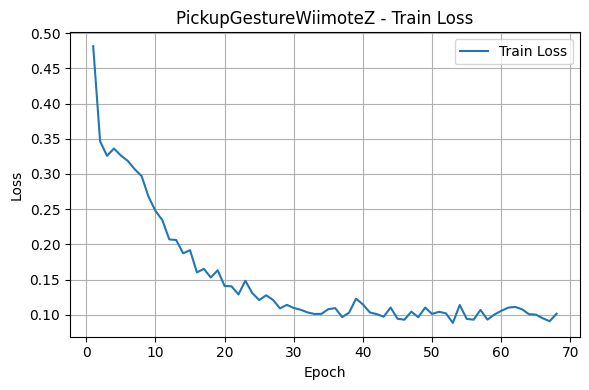

[PickupGestureWiimoteZ] TEST AUC=0.9169, TEST ACC=0.7200, n_samples=50


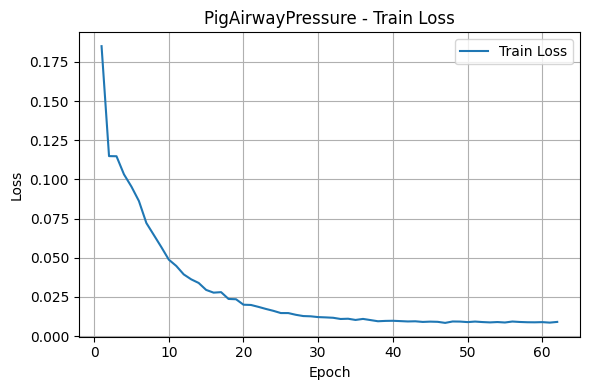

[PigAirwayPressure] TEST AUC=0.4128, TEST ACC=0.0433, n_samples=208


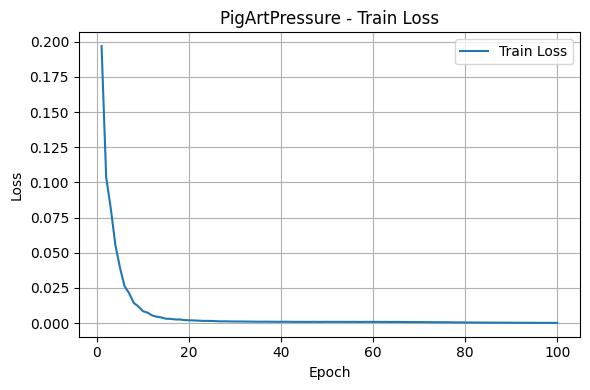

[PigArtPressure] TEST AUC=0.4350, TEST ACC=0.1106, n_samples=208


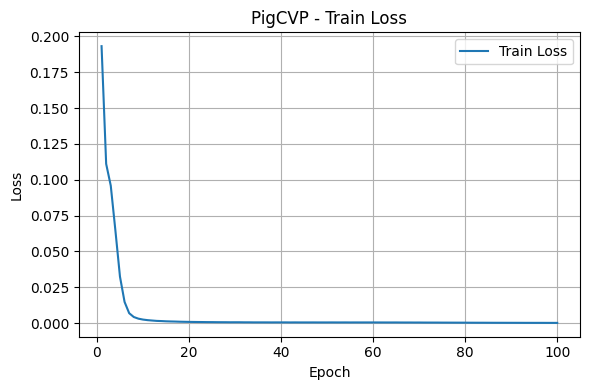

[PigCVP] TEST AUC=0.4159, TEST ACC=0.0721, n_samples=208


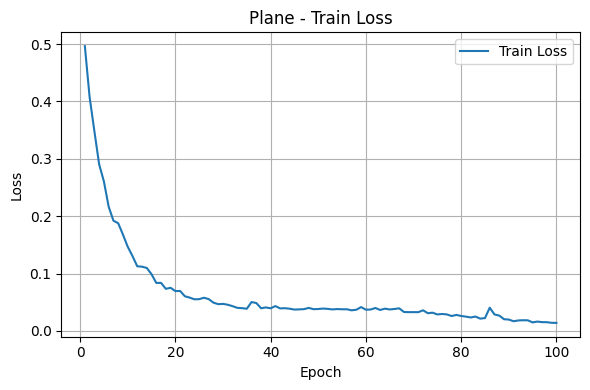

[Plane] TEST AUC=0.9988, TEST ACC=0.9619, n_samples=105


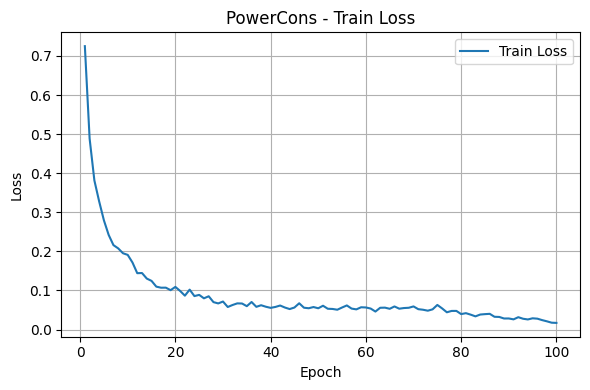

[PowerCons] TEST AUC=0.9970, TEST ACC=1.0000, n_samples=180


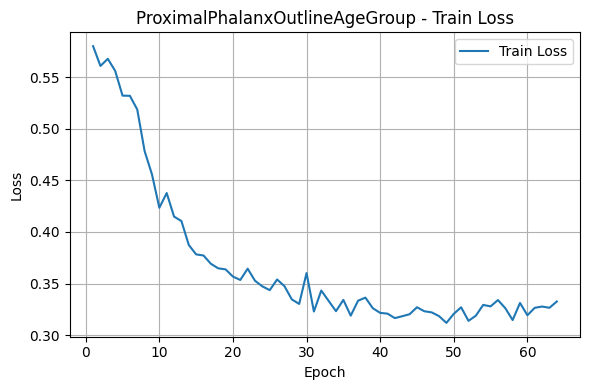

[ProximalPhalanxOutlineAgeGroup] TEST AUC=0.8093, TEST ACC=0.7830, n_samples=106


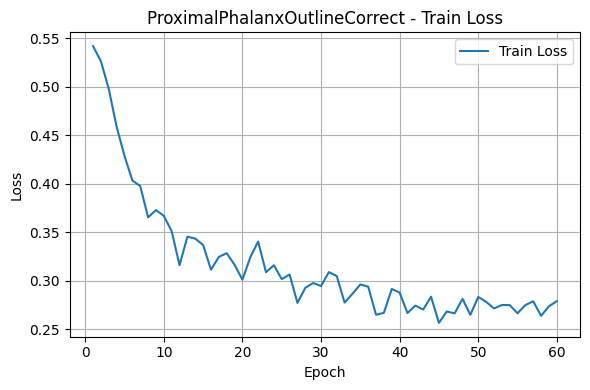

[ProximalPhalanxOutlineCorrect] TEST AUC=0.9811, TEST ACC=1.0000, n_samples=121


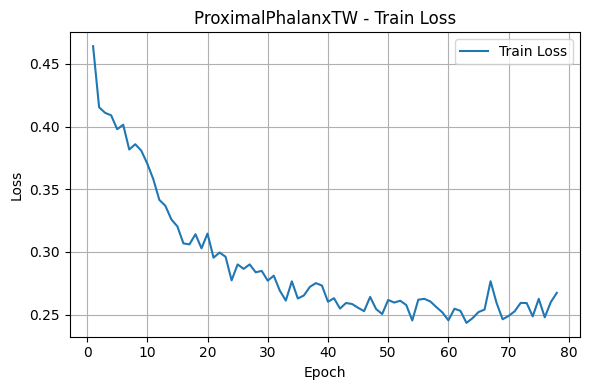

[ProximalPhalanxTW] TEST AUC=0.9018, TEST ACC=0.7073, n_samples=123


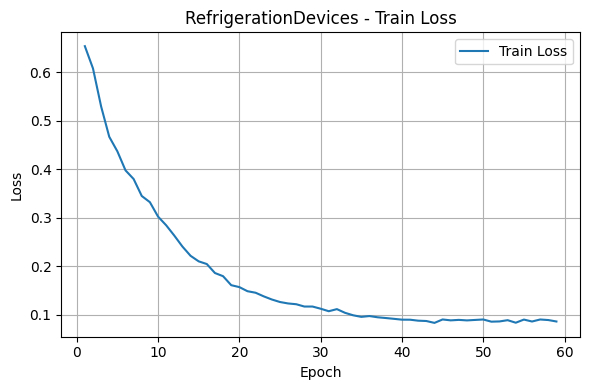

[RefrigerationDevices] TEST AUC=0.6532, TEST ACC=0.4780, n_samples=364


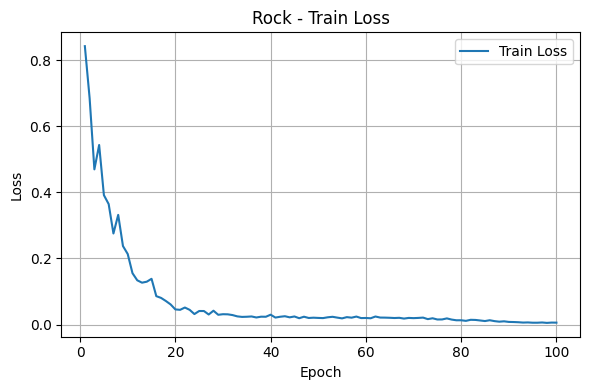

[Rock] TEST AUC=0.9367, TEST ACC=0.8000, n_samples=50


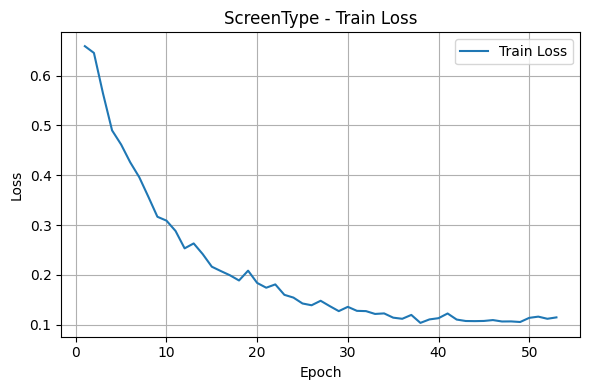

[ScreenType] TEST AUC=0.6662, TEST ACC=0.4500, n_samples=60


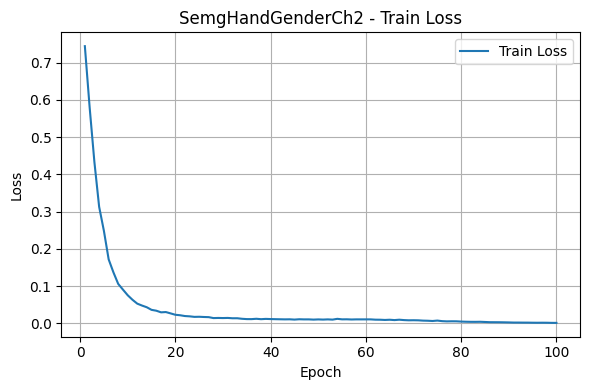

[SemgHandGenderCh2] TEST AUC=0.8871, TEST ACC=1.0000, n_samples=600


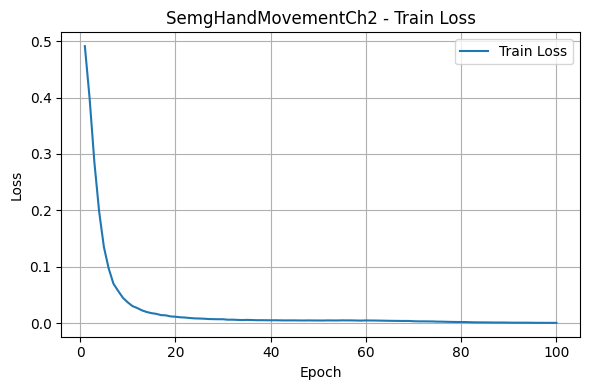

[SemgHandMovementCh2] TEST AUC=0.7421, TEST ACC=0.3756, n_samples=450


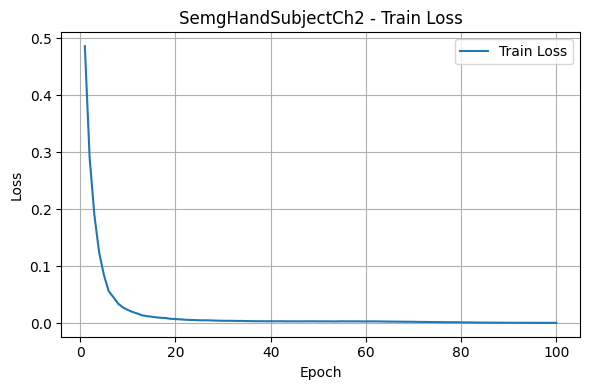

[SemgHandSubjectCh2] TEST AUC=0.9304, TEST ACC=0.7756, n_samples=450


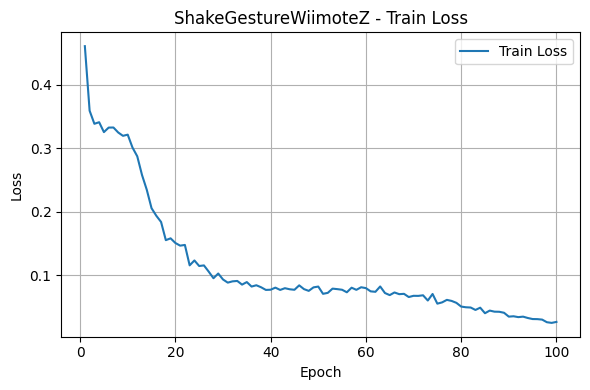

[ShakeGestureWiimoteZ] TEST AUC=0.9524, TEST ACC=0.7400, n_samples=50


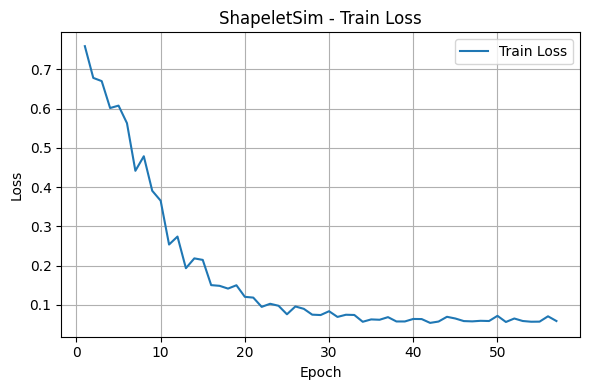

[ShapeletSim] TEST AUC=0.4020, TEST ACC=1.0000, n_samples=180


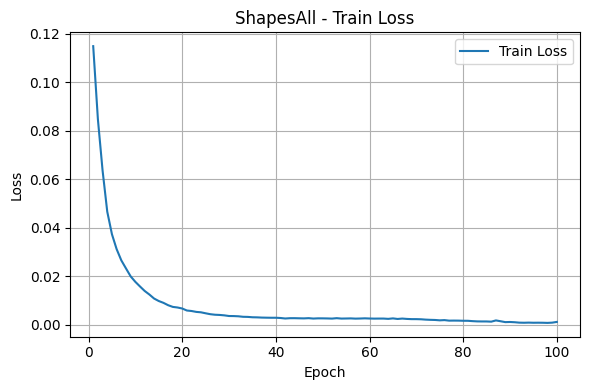

[ShapesAll] TEST AUC=0.9238, TEST ACC=0.7233, n_samples=600


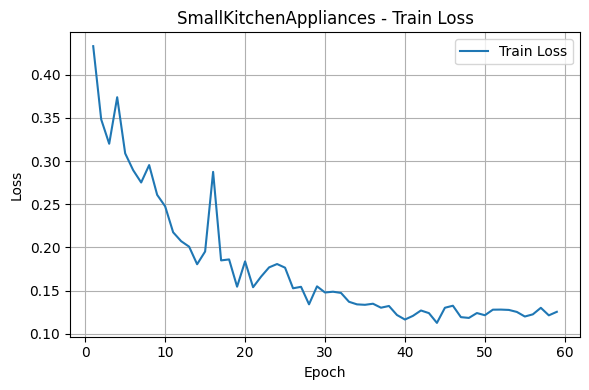

[SmallKitchenAppliances] TEST AUC=0.7222, TEST ACC=0.8246, n_samples=57


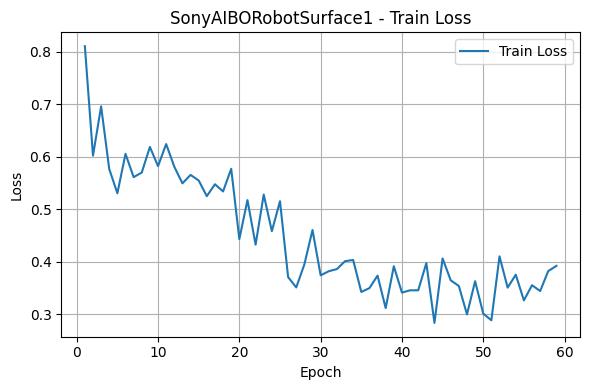

[SonyAIBORobotSurface1] TEST AUC=0.9096, TEST ACC=1.0000, n_samples=599


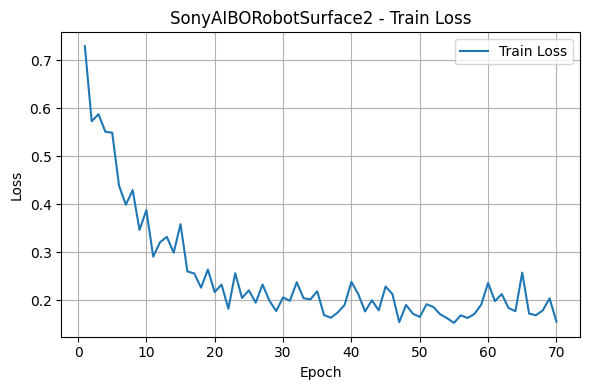

[SonyAIBORobotSurface2] TEST AUC=0.8970, TEST ACC=1.0000, n_samples=945


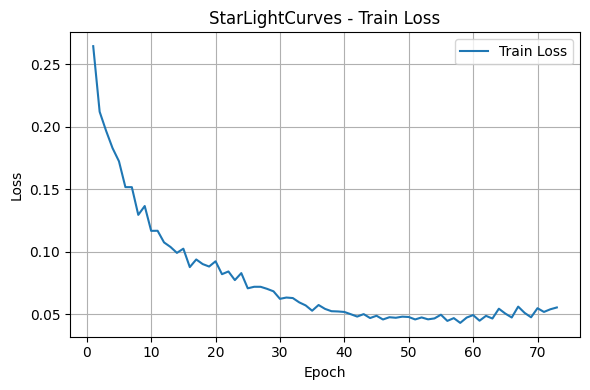

[StarLightCurves] TEST AUC=0.9807, TEST ACC=0.9325, n_samples=8236


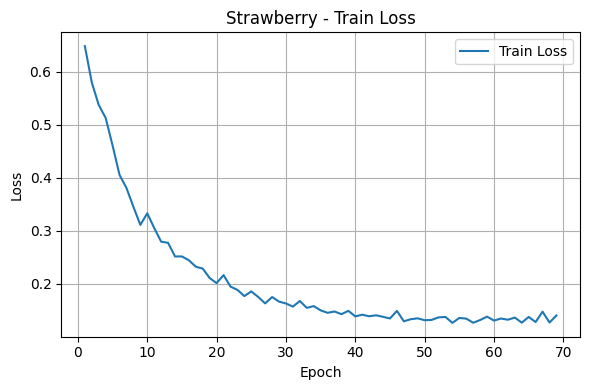

[Strawberry] TEST AUC=0.9822, TEST ACC=1.0000, n_samples=370


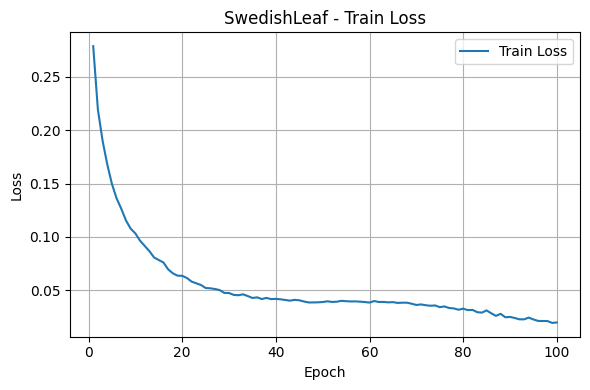

[SwedishLeaf] TEST AUC=0.9918, TEST ACC=0.8768, n_samples=625


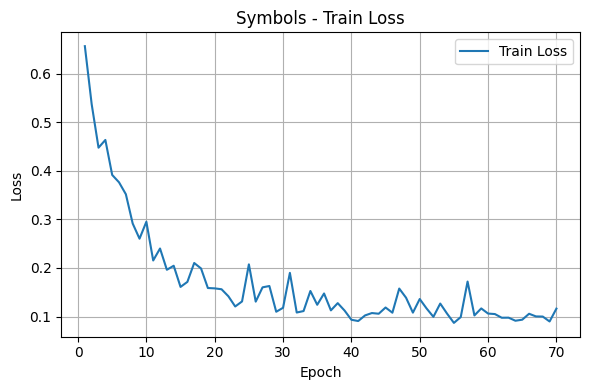

[Symbols] TEST AUC=0.9781, TEST ACC=0.8261, n_samples=995


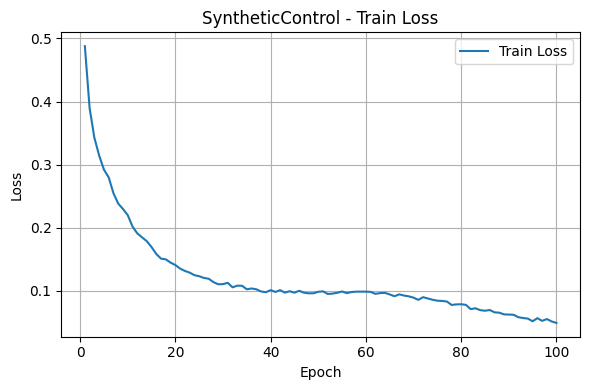

[SyntheticControl] TEST AUC=0.9792, TEST ACC=0.9533, n_samples=300


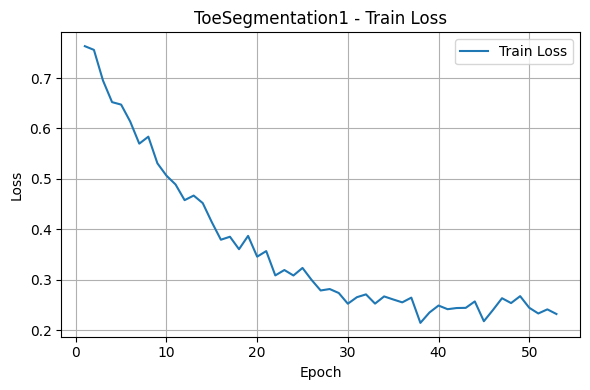

[ToeSegmentation1] TEST AUC=0.6841, TEST ACC=1.0000, n_samples=228


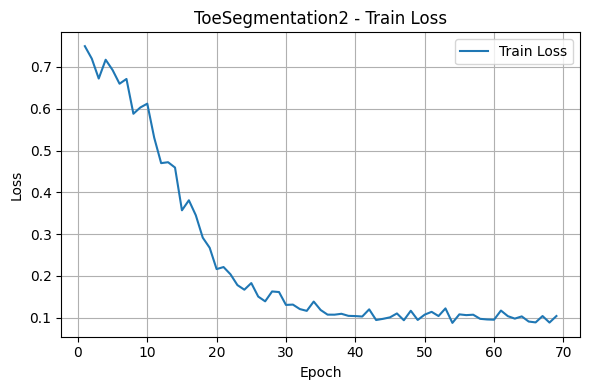

[ToeSegmentation2] TEST AUC=0.8357, TEST ACC=1.0000, n_samples=130


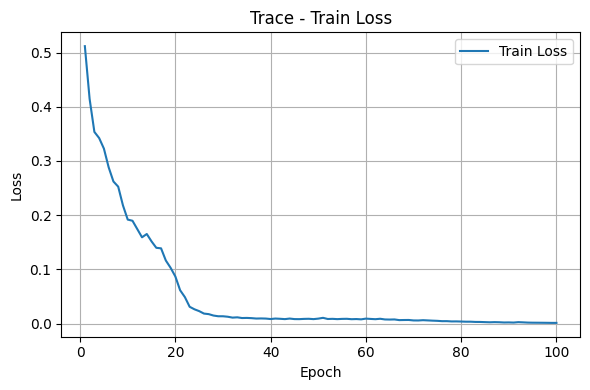

[Trace] TEST AUC=1.0000, TEST ACC=1.0000, n_samples=100


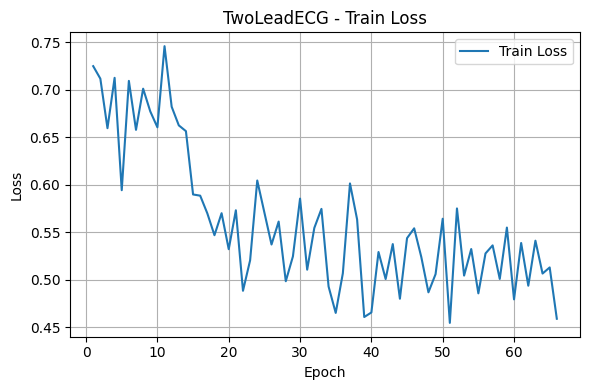

[TwoLeadECG] TEST AUC=0.6964, TEST ACC=1.0000, n_samples=1139


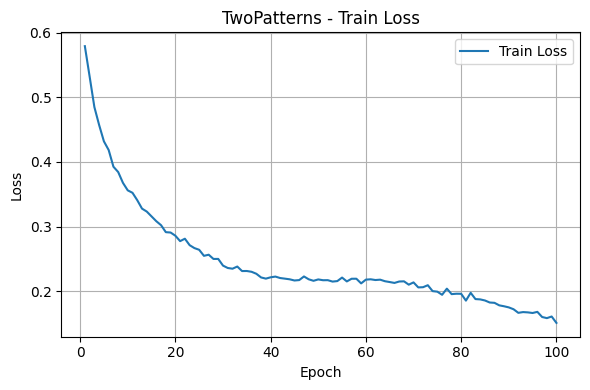

[TwoPatterns] TEST AUC=0.9353, TEST ACC=0.8049, n_samples=3957


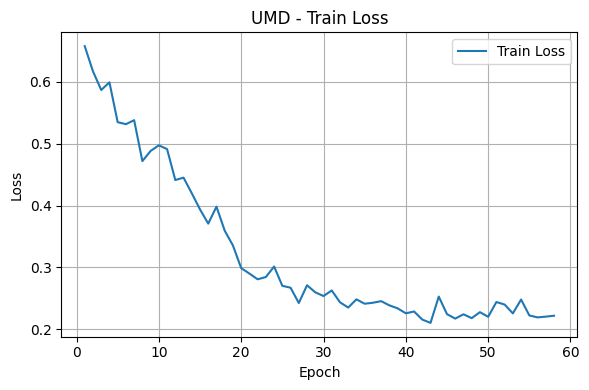

[UMD] TEST AUC=0.9410, TEST ACC=0.7847, n_samples=144


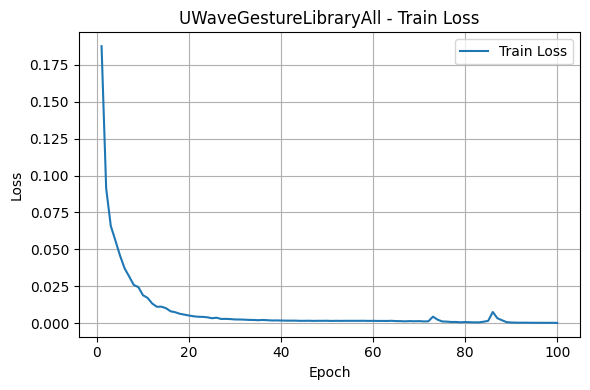

[UWaveGestureLibraryAll] TEST AUC=0.9893, TEST ACC=0.9290, n_samples=3579


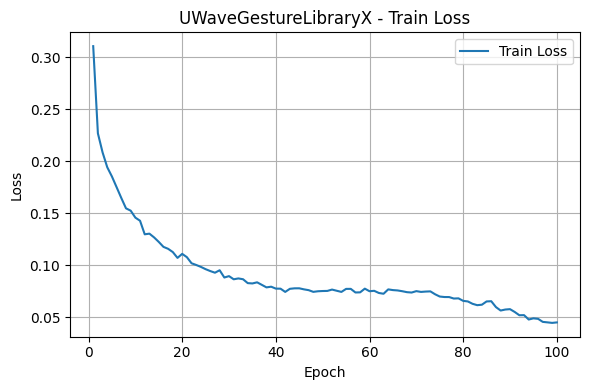

[UWaveGestureLibraryX] TEST AUC=0.9162, TEST ACC=0.7261, n_samples=3238


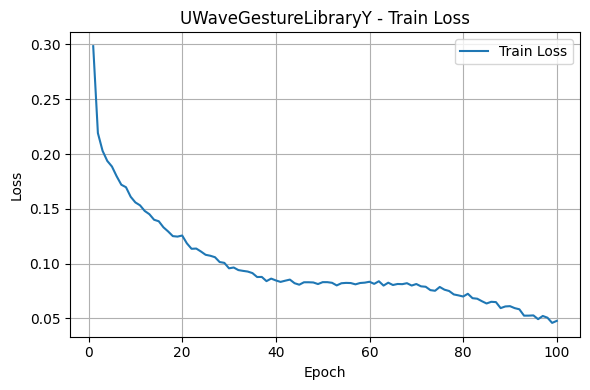

[UWaveGestureLibraryY] TEST AUC=0.9094, TEST ACC=0.6385, n_samples=3206


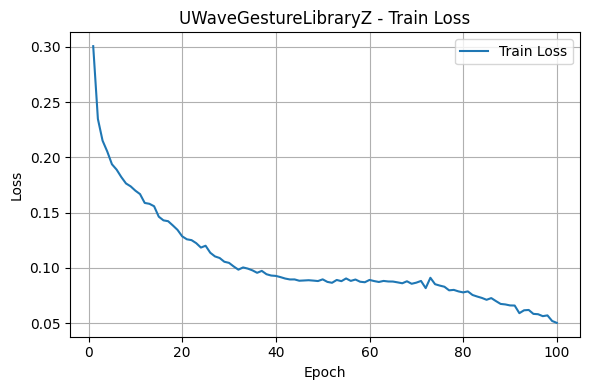

[UWaveGestureLibraryZ] TEST AUC=0.8984, TEST ACC=0.6568, n_samples=3220


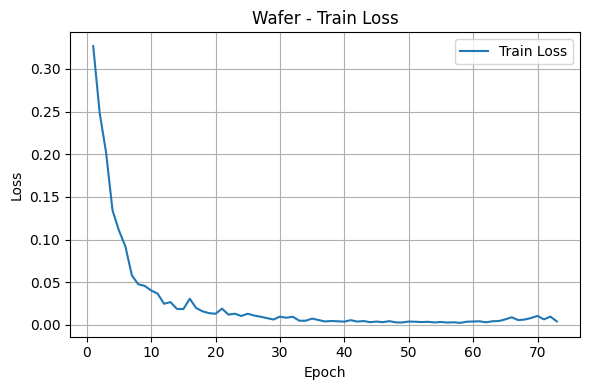

[Wafer] TEST AUC=0.9982, TEST ACC=1.0000, n_samples=5935


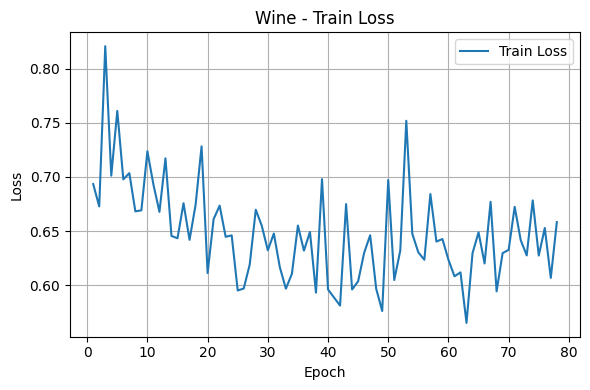

[Wine] TEST AUC=0.9506, TEST ACC=1.0000, n_samples=54


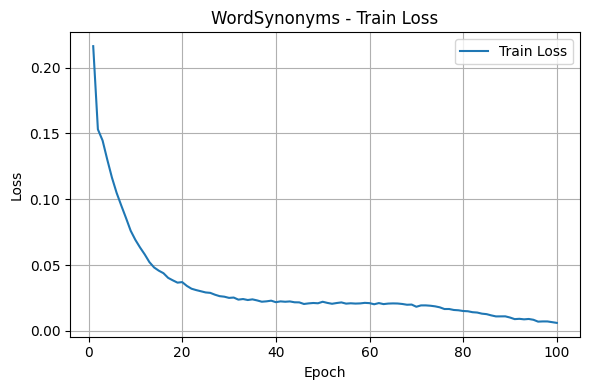

[WordSynonyms] TEST AUC=0.8253, TEST ACC=0.5752, n_samples=638


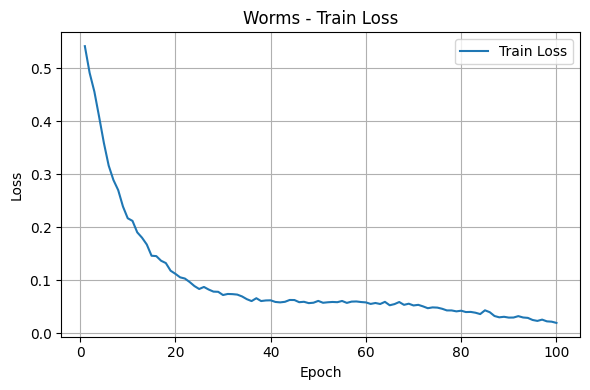

[Worms] TEST AUC=0.7208, TEST ACC=0.4675, n_samples=77


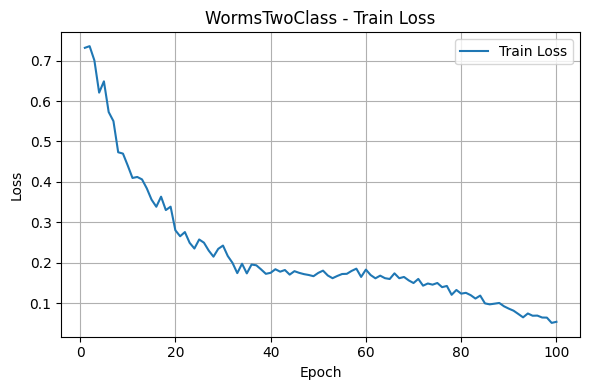

[WormsTwoClass] TEST AUC=0.5014, TEST ACC=1.0000, n_samples=77


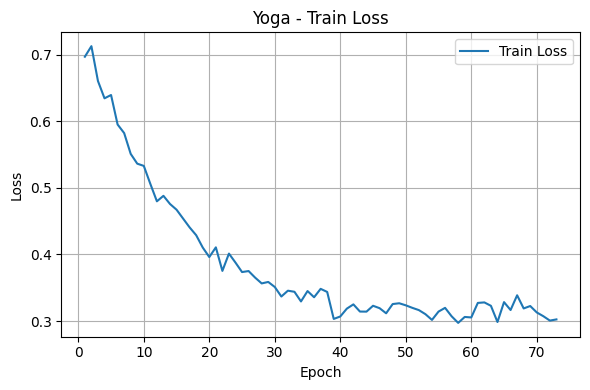

[Yoga] TEST AUC=0.8322, TEST ACC=1.0000, n_samples=3000

========== Summary (OFFICIAL TEST) ==========
                       dataset  test_auc  test_acc  n_samples
                         ACSF1  0.947333  0.700000        100
                         Adiac  0.937869  0.450128        391
            AllGestureWiimoteX  0.782212  0.386197        681
            AllGestureWiimoteY  0.867316  0.494574        645
            AllGestureWiimoteZ  0.801243  0.351825        685
                     ArrowHead  0.867040  0.640000        175
                           BME  0.923400  0.753333        150
                          Beef  0.880556  0.733333         30
                     BeetleFly  0.850000  1.000000         20
                   BirdChicken  0.730000  1.000000         20
                           CBF  0.996864  0.975556        900
                           Car  0.878343  0.700000         60
                     Chinatown  0.969794  1.000000        343
         ChlorineConcentratio

In [49]:
# Quiet run with per-dataset one-line summaries + curves + early stopping:
result = run_all_datasets(
    root=ROOT,
    device='cuda:0',
    batch_size=8,
    num_epochs=100,
    lr=1e-4,
    cap_len=None,
    verbose=False,
    plot_curves=True,
    patience=15,        # 训练早停仅基于 Train Loss
)


